# Enoncé

Vous avez participé à une compétition sur Kaggle sur le jeu de données de Titanic (celle-ci existe, les curieux peuvent la retrouver sur Kaggle !). Vous avez pour cela à votre disposition [une liste de 891 passagers](https://www.kaggle.com/c/titanic), contenant les caractéristiques suivantes :


- PassengerID : Identifiant du passager
- Survived : Indicateur de survi d'un passager (1 si le passager a survecu, 0 s’il est décédé)
- Pclass: Classe du passager (1 = 1ère classe, 2 = 2ème classe, 3 = 3ème classe)
- Name : Nom et titre du passager
- Sex : Sexe du passager
- Age : Age du passager (Décimal si inférieur à 1, estimé si de la forme xx.5)
- SibSp : Nombre d’époux, de frères et de soeurs présents à bord
- Parch : Nombre de parents ou d’enfants présents à bord 
- Ticket : Numéro du ticket 
- Fare : Tarif des tickets (Le prix est indiqué en £ et pour un seul achat (peut correspondre à plusieurs tickets)
- Cabin : Numéro de Cabine
- Embarked : Port d’embarcation (C = Cherbourg, Q = Queenstown, S = Southampton)
	 	

# Exercice

La compétition a été l’occasion de revenir sur ce jeu de données très célèbre, et plusieurs tâches étaient attendues, :
- identifier les facteurs favorisants la survie d'un passager par rapport à un autre, en dressant une typologie des survivants
- créer un algorithme qui pourrait prédire la survie d'un individu à partir de ces caractéristiques.

In [173]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import itertools
from random import randint
from sklearn import decomposition, preprocessing
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from datetime import datetime
from os import getcwd
from function import *
from mpl_toolkits.mplot3d import Axes3D
from joblib import dump, load

## 1. Charger vos données dans un DataFrame Pandas

In [2]:
# ---------------------------------------------------------------------------------------------
#                               MAIN
# ---------------------------------------------------------------------------------------------
verbose = False
verboseMain = False

print("Chargement des données...")
# Récupère le répertoire du programme
file_path = getcwd() + "\\"

Chargement des données...


In [3]:
file_name = 'titanic_dataset.csv'

df_origin = pd.read_csv(file_path+file_name, sep=',', index_col="PassengerId")

print("Chargement des données", df_origin.shape, ".... ...................................... END")

Chargement des données (891, 11) .... ...................................... END


In [4]:
df_origin.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df = df_origin.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [6]:
df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

<AxesSubplot:ylabel='PassengerId'>

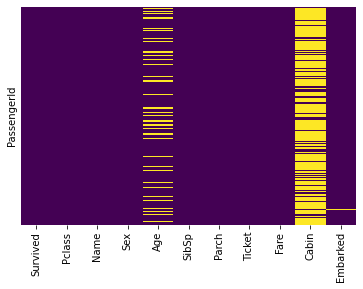

In [7]:
sns.heatmap(df.isnull(), yticklabels=False,cbar=False, cmap='viridis')

<AxesSubplot:xlabel='Survived', ylabel='count'>

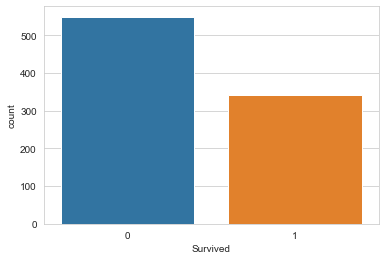

In [8]:
sns.set_style('whitegrid')
sns.countplot(x='Survived', data=df)

In [9]:
# display 
df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

#  2. Typage et Organisation des données

In [10]:
df.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [11]:
df['Sex'] = df['Sex'].astype('category')
df['sex_cat'] = df['Sex'].cat.codes
df['sex_cat']

PassengerId
1      1
2      0
3      0
4      0
5      1
      ..
887    1
888    0
889    0
890    1
891    1
Name: sex_cat, Length: 891, dtype: int8

In [12]:
df.dtypes

Survived       int64
Pclass         int64
Name          object
Sex         category
Age          float64
SibSp          int64
Parch          int64
Ticket        object
Fare         float64
Cabin         object
Embarked      object
sex_cat         int8
dtype: object

## 2.1 Ajout du titre du passager

In [13]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,sex_cat
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [14]:
df_copy = df.copy()

In [15]:
ser_name_split = df_copy["Name"].dropna().str.split("(, |\. )", n=0, expand=True)
ser_name_split

,0,1,2,3,4,5,6
PassengerId,,,,,,,
1,Braund,",",Mr,.,Owen Harris,None,None
2,Cumings,",",Mrs,.,John Bradley (Florence Briggs Thayer),None,None
3,Heikkinen,",",Miss,.,Laina,None,None
4,Futrelle,",",Mrs,.,Jacques Heath (Lily May Peel),None,None
5,Allen,",",Mr,.,William Henry,None,None
...,...,...,...,...,...,...,...
887,Montvila,",",Rev,.,Juozas,None,None
888,Graham,",",Miss,.,Margaret Edith,None,None
889,Johnston,",",Miss,.,"Catherine Helen ""Carrie""",None,None


In [16]:
ser_name_split[3].value_counts()

.     891
Name: 3, dtype: int64

In [17]:
ser_name_split[5].value_counts()

.     1
Name: 5, dtype: int64

In [18]:
ser_name_split[6].value_counts()

Barrett)    1
Name: 6, dtype: int64

In [19]:
ser_name_split[ser_name_split[6]=="Barrett)"]

,0,1,2,3,4,5,6
PassengerId,,,,,,,
514,Rothschild,",",Mrs,.,Martin (Elizabeth L,.,Barrett)


In [20]:
ser_name_split.loc[ser_name_split[6]=="Barrett)", 4]=ser_name_split.loc[ser_name_split[6]=="Barrett)", 4] +". " + ser_name_split.loc[ser_name_split[6]=="Barrett)", 6]
ser_name_split[ser_name_split[6]=="Barrett)"]

,0,1,2,3,4,5,6
PassengerId,,,,,,,
514,Rothschild,",",Mrs,.,Martin (Elizabeth L. Barrett),.,Barrett)


In [21]:
ser_name_split = ser_name_split.drop(columns=[1,3,5, 6])
ser_name_split

,0,2,4
PassengerId,,,
1,Braund,Mr,Owen Harris
2,Cumings,Mrs,John Bradley (Florence Briggs Thayer)
3,Heikkinen,Miss,Laina
4,Futrelle,Mrs,Jacques Heath (Lily May Peel)
5,Allen,Mr,William Henry
...,...,...,...
887,Montvila,Rev,Juozas
888,Graham,Miss,Margaret Edith
889,Johnston,Miss,"Catherine Helen ""Carrie"""


In [22]:
ser_name_split = ser_name_split.rename(columns={0 : "Last_name", 2:"Titre", 4:"First_name"})
ser_name_split

,Last_name,Titre,First_name
PassengerId,,,
1,Braund,Mr,Owen Harris
2,Cumings,Mrs,John Bradley (Florence Briggs Thayer)
3,Heikkinen,Miss,Laina
4,Futrelle,Mrs,Jacques Heath (Lily May Peel)
5,Allen,Mr,William Henry
...,...,...,...
887,Montvila,Rev,Juozas
888,Graham,Miss,Margaret Edith
889,Johnston,Miss,"Catherine Helen ""Carrie"""


In [23]:
ser_name_split["Titre"].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Titre, dtype: int64

Après vérification, 
* Jonkheer = Seigneur
* Mme = Mrs
* Mlle = Miss
* Lady = Miss
* Ms = Mrs or Miss
* Sir = Mr
* Don = Mr    

Correction pour homogénéiser les données

In [24]:
ser_name_split.loc[(ser_name_split["Titre"]  == "Mlle") | (ser_name_split["Titre"]  == "Lady"), "Titre"] = "Miss"
ser_name_split.loc[ser_name_split["Titre"]  == "Mme", "Titre"] = "Mrs"
ser_name_split.loc[(ser_name_split["Titre"]  == "Sir") | (ser_name_split["Titre"]  == "Don"), "Titre"] = "Mr"
ser_name_split["Titre"].value_counts()

Mr              519
Miss            185
Mrs             126
Master           40
Dr                7
Rev               6
Major             2
Col               2
Ms                1
Capt              1
the Countess      1
Jonkheer          1
Name: Titre, dtype: int64

In [25]:
type(ser_name_split)

pandas.core.frame.DataFrame

Fusion des DF

In [26]:
ser_name_split.head()

,Last_name,Titre,First_name
PassengerId,,,
1,Braund,Mr,Owen Harris
2,Cumings,Mrs,John Bradley (Florence Briggs Thayer)
3,Heikkinen,Miss,Laina
4,Futrelle,Mrs,Jacques Heath (Lily May Peel)
5,Allen,Mr,William Henry


In [27]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,sex_cat
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [28]:
df = pd.concat([df, ser_name_split], axis=1)
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,sex_cat,Last_name,Titre,First_name
PassengerId,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,Braund,Mr,Owen Harris
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,Cumings,Mrs,John Bradley (Florence Briggs Thayer)
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Heikkinen,Miss,Laina
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,Futrelle,Mrs,Jacques Heath (Lily May Peel)
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,Allen,Mr,William Henry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,1,Montvila,Rev,Juozas
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,0,Graham,Miss,Margaret Edith
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,0,Johnston,Miss,"Catherine Helen ""Carrie"""


In [29]:
df['Titre'] = df['Titre'].astype('category')
df['title_cat'] = df['Titre'].cat.codes
df['title_cat']

PassengerId
1       7
2       8
3       6
4       8
5       7
       ..
887    10
888     6
889     6
890     7
891     7
Name: title_cat, Length: 891, dtype: int8

In [30]:
df['Embarked'] = df['Embarked'].astype('category')
df['embarked_cat'] = df['Embarked'].cat.codes
df['embarked_cat']

PassengerId
1      2
2      0
3      2
4      2
5      2
      ..
887    2
888    2
889    2
890    0
891    1
Name: embarked_cat, Length: 891, dtype: int8

# 3. Nettoyer votre Dataset avec drop(), dropna() 

CORR ------------------


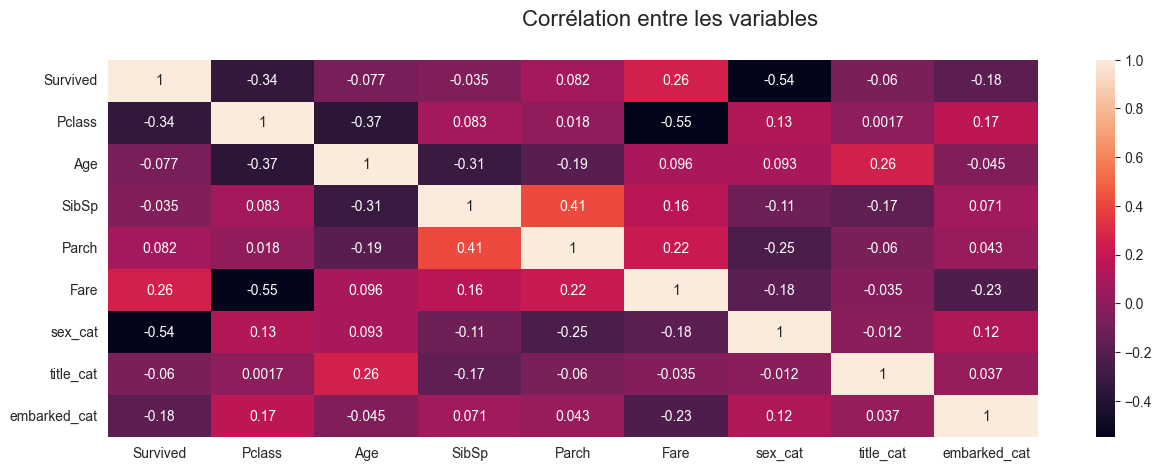

In [31]:
##on utilise data.corr et le heatmap de seborn
corr_df = df.corr()
print("CORR ------------------")
#print(corr_df, "\n")
figure, ax = color_graph_background(1,1)
figure.set_size_inches(15, 5, forward=True)
figure.set_dpi(100)
figure.suptitle("Corrélation entre les variables", fontsize=16)
sns.heatmap(corr_df, annot=True)
plt.show()

In [32]:
def calculer_a_data_on_colums(df_limit, columns_list, columnName_to_cal, type="mean"):
    group = None

    if type in "mean":
        group = df_limit.groupby(by=columns_list)[columnName_to_cal].mean()
    else:
        group = df_limit.groupby(by=columns_list)[columnName_to_cal].mean()

    new_col_name = type+"_"+columnName_to_cal
    group = group.rename(new_col_name)
    # On veut préciser le pont qui a le plus de valeurs
    group.sort_values(ascending=False)
    group_no_index = group.reset_index()
    # essai de traitement manuel

    df_manuel = df_limit.copy()
    # on merge les 2
    df_manuel = df_manuel.merge(group_no_index, on=columns_list, how='outer')
    df_manuel[new_col_name] = round(df_manuel[new_col_name], 0)
    df_manuel[columnName_to_cal] = df_manuel[columnName_to_cal].fillna(df_manuel[new_col_name])
    print(columnName_to_cal+" NA before:",df_limit[columnName_to_cal].isna().sum(),columnName_to_cal+" NA after:", df_manuel[columnName_to_cal].isna().sum())
    df_manuel = df_manuel.drop(new_col_name, axis=1)
    return df_manuel

## 3.1. PONT > traiter les ponts

### 3.1.1. PONT > déterminer le pont à partir de la cabine

Compléter les cabines pour les valeurs manquantes


De nombreuses valeurs manquantes parsèment le jeu de données.
Le nombre sur **Cabin** peut potentiellement facilement s'expliquer assez facilement : cela correspond pour une grande partie à des individus qui n'avaient simplement pas de cabine. En effet seuls les passagers de 1ère classe et certains de 2ème disposaient d'un numéro de cabine pour leur voyage.

Ces cabines étaient répartis entre les ponts A et E pour les 1ère classe, et de D à G pour les autres.
La cabine T est une cabine de classe supérieure située sur le pont A.

Si on observe rapidement la variable Cabin, on peut noter que le première caractère correspond au pont en question. On extrait donc ce dernier et on analyse la répartition des classes au sein des valeurs manquantes sur notre pont.

In [33]:
df['Cabin']

PassengerId
1       NaN
2       C85
3       NaN
4      C123
5       NaN
       ... 
887     NaN
888     B42
889     NaN
890    C148
891     NaN
Name: Cabin, Length: 891, dtype: object

Ces cabines étaient répartis entre les ponts A et E pour les 1ère classe, et de D à G pour les autres.
La cabine T est une cabine de classe supérieure située sur le pont A.

Si on observe rapidement la variable Cabin, on peut noter que le première caractère correspond au pont en question. On extrait donc ce dernier et on analyse la répartition des classes au sein des valeurs manquantes sur notre pont.

In [34]:
df['pont']= df['Cabin'].str[0]
# La cabine T est une cabine de classe supérieure située sur le pont A.
df.loc[df['pont'] == 'T','pont'] = 'A'
df['pont_fare'] = df['pont']
df['pont']

PassengerId
1      NaN
2        C
3      NaN
4        C
5      NaN
      ... 
887    NaN
888      B
889    NaN
890      C
891    NaN
Name: pont, Length: 891, dtype: object

In [35]:
VALEUR_PONT_INCONNU = "X"

In [36]:
df.loc[df['pont'].isnull(),'Pclass'].value_counts()

3    479
2    168
1     40
Name: Pclass, dtype: int64

on retrouve une majorité de 2ème et 3ème classe sans cabine, on peut leur attribuer la valeur N qui correspondra à l'absence d'attribution
Pour les 1ères classes restantes, on utilisera la moyenne payée par leurs homologues en fonction de leur pont attribué et de leur pont d'embarcation

In [37]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,sex_cat,Last_name,Titre,First_name,title_cat,embarked_cat,pont,pont_fare
PassengerId,,,,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,Braund,Mr,Owen Harris,7,2,NaN,NaN
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,Cumings,Mrs,John Bradley (Florence Briggs Thayer),8,0,C,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Heikkinen,Miss,Laina,6,2,NaN,NaN
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,Futrelle,Mrs,Jacques Heath (Lily May Peel),8,2,C,C
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,Allen,Mr,William Henry,7,2,NaN,NaN


In [38]:
df.describe(include="all")

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,sex_cat,Last_name,Titre,First_name,title_cat,embarked_cat,pont,pont_fare
count,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889,891.000000,891,891,891,891.000000,891.000000,204,204
unique,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3,NaN,667,12,799,NaN,NaN,7,7
top,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S,NaN,Andersson,Mr,John,NaN,NaN,C,C
freq,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644,NaN,9,519,9,NaN,NaN,59,59
mean,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN,0.647587,NaN,NaN,NaN,6.799102,1.529742,NaN,NaN
std,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN,0.477990,NaN,NaN,NaN,0.970948,0.800254,NaN,NaN
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,-1.000000,NaN,NaN
25%,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN,0.000000,NaN,NaN,NaN,6.000000,1.000000,NaN,NaN
50%,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN,1.000000,NaN,NaN,NaN,7.000000,2.000000,NaN,NaN
75%,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN,1.000000,NaN,NaN,NaN,7.000000,2.000000,NaN,NaN


In [39]:
def process_pont(df, fare_price_name, target_name):
    pont_group = df.groupby(by=["Pclass", "Survived", "Embarked", fare_price_name])[target_name].value_counts()
    print(pont_group.shape)
    nb_col_name = "nb_"+target_name+"_"+fare_price_name
    pont_group = pont_group.rename(nb_col_name)
    # On veut préciser le pont qui a le plus de valeurs
    pont_group.sort_values(ascending=False)

    # 142 rows × 6 columns
    pont_group_no_index = pont_group.reset_index()
    pont_group_no_index = pont_group_no_index.drop_duplicates(["Pclass","Survived","Embarked",fare_price_name], keep='first')
    pont_group_no_index = pont_group_no_index[["Pclass","Survived","Embarked",fare_price_name, "pont"]]
    pont_y_col = "ponts_temp_"+fare_price_name
    pont_group_no_index = pont_group_no_index.rename(columns={"pont":pont_y_col})

    # on merge les 2
    df_global = df.merge(pont_group_no_index, on=["Pclass","Survived","Embarked",fare_price_name], how='outer', indicator=True)
    print(pont_y_col, " NA:",df_global[pont_y_col].isna().sum())
    # On remplace les NA par la valeur par défaut
    df_global[pont_y_col] = df_global[pont_y_col].fillna(VALEUR_PONT_INCONNU)
    print(pont_y_col, " NA:",df_global[pont_y_col].isna().sum())

    # On fusionne les 2 colonnes ponts dans une nouvelle colonne
    col_pont_name = 'pont_'+fare_price_name
    df_global[col_pont_name] = df_global['pont']
    df_global[col_pont_name+"_ctr"] = np.nan
    print(df_global[col_pont_name].isna().sum())
    df_global[col_pont_name] = df_global[col_pont_name].fillna(df_global[pont_y_col])
    df_global[col_pont_name+"_ctr"] = df_global[col_pont_name+"_ctr"].fillna(df_global[pont_y_col])
    print(df_global[col_pont_name].isna().sum())

    return df_global.drop(columns=[pont_y_col, '_merge'])

### 3.1.2. PONT > NAN avec Price

In [40]:
df["price"] = round(df["Fare"], 0)
df["price2"] = round(df["Fare"], 1)
df["price3"] = round(df["Fare"], 2)
df[["price", "price2", "price3"]]

,price,price2,price3
PassengerId,,,
1,7.0,7.2,7.25
2,71.0,71.3,71.28
3,8.0,7.9,7.92
4,53.0,53.1,53.10
5,8.0,8.0,8.05
...,...,...,...
887,13.0,13.0,13.00
888,30.0,30.0,30.00
889,23.0,23.4,23.45


In [41]:
df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'sex_cat', 'Last_name', 'Titre',
       'First_name', 'title_cat', 'embarked_cat', 'pont', 'pont_fare', 'price',
       'price2', 'price3'],
      dtype='object')

In [42]:
df_global = process_pont(df[['Survived', 'Pclass', 'sex_cat', 'Titre', 'title_cat', 'Age', 'SibSp', 'Parch',
       'Fare', 'Cabin', 'Embarked', 'embarked_cat', 'pont', 'pont_fare', 'price',
       'price2', 'price3', 'Last_name','First_name']], "price", "pont")

(142,)
ponts_temp_price  NA: 402
ponts_temp_price  NA: 0
687
0


In [43]:
df_global

,Survived,Pclass,sex_cat,Titre,title_cat,Age,SibSp,Parch,Fare,Cabin,...,embarked_cat,pont,pont_fare,price,price2,price3,Last_name,First_name,pont_price,pont_price_ctr
0,0,3,1,Mr,7,22.0,1,0,7.2500,NaN,...,2,NaN,NaN,7.0,7.2,7.25,Braund,Owen Harris,X,X
1,0,3,1,Mr,7,59.0,0,0,7.2500,NaN,...,2,NaN,NaN,7.0,7.2,7.25,Coxon,Daniel,X,X
2,0,3,1,Mr,7,45.0,0,0,6.9750,NaN,...,2,NaN,NaN,7.0,7.0,6.98,Ekstrom,Johan,X,X
3,0,3,1,Mr,7,20.0,0,0,7.0500,NaN,...,2,NaN,NaN,7.0,7.0,7.05,Coelho,Domingos Fernandeo,X,X
4,0,3,1,Mr,7,NaN,0,0,7.3125,NaN,...,2,NaN,NaN,7.0,7.3,7.31,Olsen,Ole Martin,X,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,Rev,10,28.0,0,1,33.0000,NaN,...,2,NaN,NaN,33.0,33.0,33.00,Harper,John,X,X
887,1,1,0,Miss,6,16.0,0,1,39.4000,D28,...,2,D,D,39.0,39.4,39.40,Lines,Mary Conover,D,D
888,0,1,1,Mr,7,33.0,0,0,5.0000,B51 B53 B55,...,2,B,B,5.0,5.0,5.00,Carlsson,Frans Olof,B,B
889,1,2,0,Mrs,8,28.0,1,0,24.0000,NaN,...,0,NaN,NaN,24.0,24.0,24.00,Abelson,Samuel (Hannah Wizosky),X,X


In [44]:
df_global = process_pont(df_global, "price2", "pont")

(146,)
ponts_temp_price2  NA: 579
ponts_temp_price2  NA: 0
687
0


In [45]:
df_global = process_pont(df_global, "price3", "pont")

(146,)
ponts_temp_price3  NA: 584
ponts_temp_price3  NA: 0
687
0


In [46]:
df_global

,Survived,Pclass,sex_cat,Titre,title_cat,Age,SibSp,Parch,Fare,Cabin,...,price2,price3,Last_name,First_name,pont_price,pont_price_ctr,pont_price2,pont_price2_ctr,pont_price3,pont_price3_ctr
0,0,3,1,Mr,7,22.0,1,0,7.2500,NaN,...,7.2,7.25,Braund,Owen Harris,X,X,X,X,X,X
1,0,3,1,Mr,7,59.0,0,0,7.2500,NaN,...,7.2,7.25,Coxon,Daniel,X,X,X,X,X,X
2,0,3,1,Mr,7,22.0,0,0,7.2500,NaN,...,7.2,7.25,Perkin,John Henry,X,X,X,X,X,X
3,0,3,1,Mr,7,20.5,0,0,7.2500,NaN,...,7.2,7.25,Lovell,"John Hall (""Henry"")",X,X,X,X,X,X
4,0,3,1,Mr,7,NaN,0,0,7.2500,NaN,...,7.2,7.25,Reed,James George,X,X,X,X,X,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,3,1,Mr,7,34.5,0,0,6.4375,NaN,...,6.4,6.44,Lemberopolous,Peter L,X,X,X,X,X,X
887,0,2,1,Rev,10,28.0,0,1,33.0000,NaN,...,33.0,33.00,Harper,John,X,X,X,X,X,X
888,1,1,0,Miss,6,16.0,0,1,39.4000,D28,...,39.4,39.40,Lines,Mary Conover,D,D,D,D,D,D
889,0,1,1,Mr,7,33.0,0,0,5.0000,B51 B53 B55,...,5.0,5.00,Carlsson,Frans Olof,B,B,B,B,B,B


Vérification des résultats par rapport à ce que nous avons extrait via la cabine

In [47]:
df_global.columns


Index(['Survived', 'Pclass', 'sex_cat', 'Titre', 'title_cat', 'Age', 'SibSp',
       'Parch', 'Fare', 'Cabin', 'Embarked', 'embarked_cat', 'pont',
       'pont_fare', 'price', 'price2', 'price3', 'Last_name', 'First_name',
       'pont_price', 'pont_price_ctr', 'pont_price2', 'pont_price2_ctr',
       'pont_price3', 'pont_price3_ctr'],
      dtype='object')

In [48]:
df_global_temp = df_global[['Fare',
       'price', 'price2', 'price3', 'Embarked', 'Cabin', 'pont','pont_price_ctr', 'pont_price2_ctr', 'pont_price3_ctr', 'pont_price',
        'pont_price2','pont_price3', 'Survived', 'Pclass', 'sex_cat', 'Age', ]]

In [49]:
tp1 = df_global_temp[(df_global_temp["pont_price_ctr"]!=df_global_temp["pont"]) & (df_global_temp["pont"].notna())]
tp2 = df_global_temp[(df_global_temp["pont_price2_ctr"]!=df_global_temp["pont"]) & (df_global_temp["pont"].notna())]
tp3 = df_global_temp[(df_global_temp["pont_price3_ctr"]!=df_global_temp["pont"]) & (df_global_temp["pont"].notna())]

In [50]:
print("- il y a", round((tp1.shape[0]/df_global_temp["pont"].notna().sum()*100),2), "% d'échec sur la déduction du pont avec un prix arrondi avec 0 décimale (", tp1.shape[0], "/", df_global_temp["pont"].notna().sum(), ")")
print("- il y a", round((tp2.shape[0]/df_global_temp["pont"].notna().sum()*100),2), "% d'échec sur la déduction du pont avec un prix arrondi avec 1 décimale (", tp2.shape[0], "/", df_global_temp["pont"].notna().sum(), ")")
print("- il y a", round((tp3.shape[0]/df_global_temp["pont"].notna().sum()*100),2), "% d'échec sur la déduction du pont avec un prix arrondi avec 2 décimales (", tp3.shape[0], "/", df_global_temp["pont"].notna().sum(), ")")

- il y a 16.18 % d'échec sur la déduction du pont avec un prix arrondi avec 0 décimale ( 33 / 204 )
- il y a 10.78 % d'échec sur la déduction du pont avec un prix arrondi avec 1 décimale ( 22 / 204 )
- il y a 10.29 % d'échec sur la déduction du pont avec un prix arrondi avec 2 décimales ( 21 / 204 )


Il est donc préférable de se baser en premier lieu sur la méthode à 2 décimales

In [51]:
tp3 = df_global_temp[(df_global_temp["pont_price3_ctr"]!=df_global_temp["pont"]) & (df_global_temp["pont"].notna()) & (df_global_temp["pont_price3_ctr"]!=df_global_temp["pont_price2_ctr"]) ]
print(tp3.shape)
tp3

(0, 17)


,Fare,price,price2,price3,Embarked,Cabin,pont,pont_price_ctr,pont_price2_ctr,pont_price3_ctr,pont_price,pont_price2,pont_price3,Survived,Pclass,sex_cat,Age


In [52]:
tp5 = df_global_temp[(df_global_temp["pont_price2_ctr"]!=df_global_temp["pont_price_ctr"]) ]
print("- nb différences entre 0 décimale et 1 décimale", tp5.shape[0], "soit", round((tp5.shape[0]/df_global_temp.shape[0]*100),2), "%")
tp6 = df_global_temp[(df_global_temp["pont_price3_ctr"]!=df_global_temp["pont_price_ctr"]) ]
print("- nb différences entre 0 décimale et 2 décimales", tp6.shape[0], "soit", round((tp6.shape[0]/df_global_temp.shape[0]*100),2), "%")
tp4 = df_global_temp[(df_global_temp["pont_price3_ctr"]!=df_global_temp["pont_price2_ctr"]) ]
print("- nb différences entre 1 décimales et 2 décimales", tp4.shape[0], "soit", round((tp4.shape[0]/df_global_temp.shape[0]*100),2), "%")

- nb différences entre 0 décimale et 1 décimale 193 soit 21.66 %
- nb différences entre 0 décimale et 2 décimales 197 soit 22.11 %
- nb différences entre 1 décimales et 2 décimales 6 soit 0.67 %


Horsmis la ligne mieux imputée pour la version à 2 décimales, avec 1 et 2 décimales, nous obtenons les mêmes résultats

#### 3.1.2.1. En utilisant Fare

In [53]:
df_global = process_pont(df_global, "Fare", "pont")

(146,)
ponts_temp_Fare  NA: 584
ponts_temp_Fare  NA: 0
687
0


In [54]:
df_global

,Survived,Pclass,sex_cat,Titre,title_cat,Age,SibSp,Parch,Fare,Cabin,...,Last_name,First_name,pont_price,pont_price_ctr,pont_price2,pont_price2_ctr,pont_price3,pont_price3_ctr,pont_Fare,pont_Fare_ctr
0,0,3,1,Mr,7,22.0,1,0,7.2500,NaN,...,Braund,Owen Harris,X,X,X,X,X,X,X,X
1,0,3,1,Mr,7,59.0,0,0,7.2500,NaN,...,Coxon,Daniel,X,X,X,X,X,X,X,X
2,0,3,1,Mr,7,22.0,0,0,7.2500,NaN,...,Perkin,John Henry,X,X,X,X,X,X,X,X
3,0,3,1,Mr,7,20.5,0,0,7.2500,NaN,...,Lovell,"John Hall (""Henry"")",X,X,X,X,X,X,X,X
4,0,3,1,Mr,7,NaN,0,0,7.2500,NaN,...,Reed,James George,X,X,X,X,X,X,X,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,3,1,Mr,7,34.5,0,0,6.4375,NaN,...,Lemberopolous,Peter L,X,X,X,X,X,X,X,X
887,0,2,1,Rev,10,28.0,0,1,33.0000,NaN,...,Harper,John,X,X,X,X,X,X,X,X
888,1,1,0,Miss,6,16.0,0,1,39.4000,D28,...,Lines,Mary Conover,D,D,D,D,D,D,D,D
889,0,1,1,Mr,7,33.0,0,0,5.0000,B51 B53 B55,...,Carlsson,Frans Olof,B,B,B,B,B,B,B,B


Même vérification qu'avec les précédentes méthodes

#### 3.1.2.3. Comparaison Fare et Price

In [55]:
tp7 = df_global[(df_global["pont_Fare_ctr"]!=df_global_temp["pont"]) & (df_global_temp["pont"].notna())]
print("- il y a", round((tp3.shape[0]/df_global_temp["pont"].notna().sum()*100),2), "% d'échec sur la déduction du pont avec un prix arrondi avec 2 décimales (", tp3.shape[0], "/", df_global_temp["pont"].notna().sum(), ")")
print("- il y a", round((tp7.shape[0]/df_global_temp["pont"].notna().sum()*100),2), "% d'échec sur la déduction du pont avec FARE (", tp7.shape[0], "/", df_global_temp["pont"].notna().sum(), ")")

- il y a 0.0 % d'échec sur la déduction du pont avec un prix arrondi avec 2 décimales ( 0 / 204 )
- il y a 9.8 % d'échec sur la déduction du pont avec FARE ( 20 / 204 )


In [56]:
tp8 = df_global[(df_global["pont_price3_ctr"]!=df_global["pont_Fare_ctr"]) ]
print("- nb différences entre 2 décimales et Fare", tp8.shape[0], "soit", round((tp8.shape[0]/df_global.shape[0]*100),2), "%")

- nb différences entre 2 décimales et Fare 1 soit 0.11 %


In [57]:
df_global["pont_Fare_ctr"].value_counts()

X    584
C     73
F     65
B     48
E     47
D     45
A     25
G      4
Name: pont_Fare_ctr, dtype: int64

In [58]:
df_global["pont_price3_ctr"].value_counts()

X    584
C     72
F     65
B     49
E     47
D     45
A     25
G      4
Name: pont_price3_ctr, dtype: int64

In [59]:
df_global["pont_price2_ctr"].value_counts()

X    579
C     72
F     69
B     49
E     48
D     44
A     25
G      5
Name: pont_price2_ctr, dtype: int64

In [60]:
df_global["pont_price_ctr"].value_counts()

X    402
F    204
C     81
E     66
B     49
D     45
A     26
G     18
Name: pont_price_ctr, dtype: int64

In [61]:
df_temp = df_global[((df_global["pont_price3"] != df_global["pont_Fare"]))]
print(df_temp.shape)
df_temp

tp3 = df_global_temp[(df_global_temp["pont_price3_ctr"]!=df_global_temp["pont"]) & (df_global_temp["pont"].notna()) & (df_global_temp["pont_price3_ctr"]!=df_global_temp["pont_price2_ctr"]) ]
print(tp3.shape)
tp3

(0, 27)
(0, 17)


,Fare,price,price2,price3,Embarked,Cabin,pont,pont_price_ctr,pont_price2_ctr,pont_price3_ctr,pont_price,pont_price2,pont_price3,Survived,Pclass,sex_cat,Age


L'arrondit avec 2 décimales donne le même résultat que l'utilisation de Fare

Au vu de ces analyses, il est préférable de travailler avec le FARE, puis l'arrondie à 1 décimale (l'arrondie à 2 décimales n'apporte pas une grande amélioration), puis aucune décimale

In [62]:
df_global_full = df_global.copy()

In [63]:
df_global = df_global.drop(columns=["pont_price3", "pont_price3_ctr"])

In [64]:
df_temp = df_global[((df_global["pont_price2"] != df_global["pont_Fare"]) & (df_global["pont_price2"] != df_global["pont_price"]))]
print(df_temp.shape)
df_temp

(1, 25)


,Survived,Pclass,sex_cat,Titre,title_cat,Age,SibSp,Parch,Fare,Cabin,...,price2,price3,Last_name,First_name,pont_price,pont_price_ctr,pont_price2,pont_price2_ctr,pont_Fare,pont_Fare_ctr
535,0,3,0,Miss,6,22.0,0,0,10.5167,NaN,...,10.5,10.52,Dahlberg,Gerda Ulrika,X,X,G,G,X,X


1 seule valeur est différente en utilisant une seule décimale, il faut vérifier si c'est réellement intéressant ou s'il s'agit d'une erreur

In [65]:
df_global[(df_global['Fare'] >=10.0) & (df_global['Fare'] <= 11.0) & (df_global['Cabin'].notna())]

,Survived,Pclass,sex_cat,Titre,title_cat,Age,SibSp,Parch,Fare,Cabin,...,price2,price3,Last_name,First_name,pont_price,pont_price_ctr,pont_price2,pont_price2_ctr,pont_Fare,pont_Fare_ctr
367,0,2,0,Mrs,8,57.0,0,0,10.5000,E77,...,10.5,10.50,Mack,(Mary),E,E,E,E,E,E
448,1,2,0,Mrs,8,29.0,0,0,10.5000,F33,...,10.5,10.50,Nye,(Elizabeth Ramell),F,F,F,F,F,F
452,1,2,0,Mrs,8,34.0,0,0,10.5000,F33,...,10.5,10.50,Lemore,(Amelia Milley),F,F,F,F,F,F
455,1,2,0,Miss,6,27.0,0,0,10.5000,E101,...,10.5,10.50,Troutt,"Edwina Celia ""Winnie""",E,F,E,F,E,F
533,0,3,0,Miss,6,2.0,0,1,10.4625,G6,...,10.5,10.46,Strom,Telma Matilda,G,G,G,G,G,G
534,0,3,0,Mrs,8,29.0,1,1,10.4625,G6,...,10.5,10.46,Strom,Wilhelm (Elna Matilda Persson),G,G,G,G,G,G


Il y a 6 passagers dans ce tarif et 2 seulement de la même classe et du même embarquement avec le même arrondit price 2, le Fare étant 10.51 il est arrondit à 11 pour le price... et aucun donnée ne correspond

In [66]:
df_temp = df_global[((df_global["pont_price2"] != df_global["pont_price"]) & (df_global["pont_price2"] != 'X'))]
print(df_temp.shape)
df_temp

(1, 25)


,Survived,Pclass,sex_cat,Titre,title_cat,Age,SibSp,Parch,Fare,Cabin,...,price2,price3,Last_name,First_name,pont_price,pont_price_ctr,pont_price2,pont_price2_ctr,pont_Fare,pont_Fare_ctr
535,0,3,0,Miss,6,22.0,0,0,10.5167,NaN,...,10.5,10.52,Dahlberg,Gerda Ulrika,X,X,G,G,X,X


C'est le seul cas différent entre l'arrondit à 0 ou 1 décimale, on récupère la valeur et on peut supprimer la colonne

In [67]:
df_global.loc[((df_global["pont_price2"] != df_global["pont_price"]) & (df_global["pont_price2"] != 'X')), "pont_price"] = df_global["pont_price2"]

In [68]:
df_global[df_global["Fare"] == 10.5167]

,Survived,Pclass,sex_cat,Titre,title_cat,Age,SibSp,Parch,Fare,Cabin,...,price2,price3,Last_name,First_name,pont_price,pont_price_ctr,pont_price2,pont_price2_ctr,pont_Fare,pont_Fare_ctr
535,0,3,0,Miss,6,22.0,0,0,10.5167,NaN,...,10.5,10.52,Dahlberg,Gerda Ulrika,G,X,G,G,X,X


In [69]:
df_global = df_global.drop(columns=["pont_price2", "pont_price2_ctr"])

In [70]:
df = df_global.copy()
df

,Survived,Pclass,sex_cat,Titre,title_cat,Age,SibSp,Parch,Fare,Cabin,...,pont_fare,price,price2,price3,Last_name,First_name,pont_price,pont_price_ctr,pont_Fare,pont_Fare_ctr
0,0,3,1,Mr,7,22.0,1,0,7.2500,NaN,...,NaN,7.0,7.2,7.25,Braund,Owen Harris,X,X,X,X
1,0,3,1,Mr,7,59.0,0,0,7.2500,NaN,...,NaN,7.0,7.2,7.25,Coxon,Daniel,X,X,X,X
2,0,3,1,Mr,7,22.0,0,0,7.2500,NaN,...,NaN,7.0,7.2,7.25,Perkin,John Henry,X,X,X,X
3,0,3,1,Mr,7,20.5,0,0,7.2500,NaN,...,NaN,7.0,7.2,7.25,Lovell,"John Hall (""Henry"")",X,X,X,X
4,0,3,1,Mr,7,NaN,0,0,7.2500,NaN,...,NaN,7.0,7.2,7.25,Reed,James George,X,X,X,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,3,1,Mr,7,34.5,0,0,6.4375,NaN,...,NaN,6.0,6.4,6.44,Lemberopolous,Peter L,X,X,X,X
887,0,2,1,Rev,10,28.0,0,1,33.0000,NaN,...,NaN,33.0,33.0,33.00,Harper,John,X,X,X,X
888,1,1,0,Miss,6,16.0,0,1,39.4000,D28,...,D,39.0,39.4,39.40,Lines,Mary Conover,D,D,D,D
889,0,1,1,Mr,7,33.0,0,0,5.0000,B51 B53 B55,...,B,5.0,5.0,5.00,Carlsson,Frans Olof,B,B,B,B


### 3.1.3 seconde possibilité pour le pont

Application de la méthode de Marwa pour comparer les résultats

In [71]:
def get_closest(Fare, Embarked, prixDeck_df, colName='pont'):
    prixDeck = prixDeck_df.loc[prixDeck_df['Embarked'] == Embarked,:]
    return prixDeck.loc[prixDeck['Fare'].sub(Fare).abs().idxmin(), colName]

In [72]:
def process_deck_1(df, deck_name = "deck1"):
    df[deck_name]= df['Cabin'].str[0] 
    df.loc[df[deck_name] == 'T', deck_name] = 'A'
    df[deck_name+"_control"]= np.NaN
    df.loc[(df[deck_name].isnull()) & (df['Pclass'].isin([2,3])), deck_name] = VALEUR_PONT_INCONNU
    mask = df[deck_name].isnull()
    colName='pont'
    prixDeck = df.loc[df['Pclass']==1, [colName, 'Embarked', 'Fare']].groupby([colName, 'Embarked']).mean().reset_index()
    prixDeck = prixDeck.sort_values('Fare', ascending=False)
    print(prixDeck.shape)
    df.loc[mask, deck_name] = df.loc[mask, :].apply(lambda x: get_closest(x['Fare'], x['Embarked'], prixDeck), axis=1)
    df.loc[mask,deck_name+"_control"] = df.loc[mask,:].apply(lambda x: get_closest(x['Fare'], x['Embarked'], prixDeck), axis=1)
    print(deck_name,"NA :",df[deck_name].isnull().sum(), deck_name+"_control NA :",df[deck_name+"_control"].isnull().sum())
    return df

In [73]:
df = process_deck_1(df)
df.head()

(15, 3)
deck1 NA : 0 deck1_control NA : 851


,Survived,Pclass,sex_cat,Titre,title_cat,Age,SibSp,Parch,Fare,Cabin,...,price2,price3,Last_name,First_name,pont_price,pont_price_ctr,pont_Fare,pont_Fare_ctr,deck1,deck1_control
0,0,3,1,Mr,7,22.0,1,0,7.25,NaN,...,7.2,7.25,Braund,Owen Harris,X,X,X,X,X,NaN
1,0,3,1,Mr,7,59.0,0,0,7.25,NaN,...,7.2,7.25,Coxon,Daniel,X,X,X,X,X,NaN
2,0,3,1,Mr,7,22.0,0,0,7.25,NaN,...,7.2,7.25,Perkin,John Henry,X,X,X,X,X,NaN
3,0,3,1,Mr,7,20.5,0,0,7.25,NaN,...,7.2,7.25,Lovell,"John Hall (""Henry"")",X,X,X,X,X,NaN
4,0,3,1,Mr,7,NaN,0,0,7.25,NaN,...,7.2,7.25,Reed,James George,X,X,X,X,X,NaN


In [74]:
def get_closest2(Fare, Embarked, prixDeck, colName='pont'):
    # print("get_closest2(Fare, Embarked, prixDeck, colName='pont')", Fare, Embarked, prixDeck, colName)
    prixDeck = prixDeck.loc[prixDeck['Embarked'] == Embarked,:]
    # print(prixDeck)
    prixDeck = prixDeck.loc[prixDeck['Fare'].sub(Fare).abs().idxmin(), colName]
    # print(prixDeck)
    return prixDeck

In [75]:
def process_deck_2(df, deck_name = "deck2"):
    colName='pont'
    df[deck_name]= df[colName]
    df.loc[(df[deck_name].isnull()) & (df['Pclass'].isin([2,3])), deck_name] = VALEUR_PONT_INCONNU
    prixDeck = df.loc[df['Pclass']==1,[colName, 'Embarked','Fare','Pclass']].groupby([colName,'Embarked','Fare']).count().reset_index().drop('Pclass',axis=1)
    mask = df[deck_name].isnull()

    df.loc[mask,deck_name] = df.loc[mask,:].apply(lambda x: get_closest2(x['Fare'], x['Embarked'], prixDeck), axis=1)
    print(deck_name,"NA :",df[deck_name].isnull().sum())
    return df

In [76]:
df = process_deck_2(df)
df.head()

deck2 NA : 0


,Survived,Pclass,sex_cat,Titre,title_cat,Age,SibSp,Parch,Fare,Cabin,...,price3,Last_name,First_name,pont_price,pont_price_ctr,pont_Fare,pont_Fare_ctr,deck1,deck1_control,deck2
0,0,3,1,Mr,7,22.0,1,0,7.25,NaN,...,7.25,Braund,Owen Harris,X,X,X,X,X,NaN,X
1,0,3,1,Mr,7,59.0,0,0,7.25,NaN,...,7.25,Coxon,Daniel,X,X,X,X,X,NaN,X
2,0,3,1,Mr,7,22.0,0,0,7.25,NaN,...,7.25,Perkin,John Henry,X,X,X,X,X,NaN,X
3,0,3,1,Mr,7,20.5,0,0,7.25,NaN,...,7.25,Lovell,"John Hall (""Henry"")",X,X,X,X,X,NaN,X
4,0,3,1,Mr,7,NaN,0,0,7.25,NaN,...,7.25,Reed,James George,X,X,X,X,X,NaN,X


In [77]:
df_global_temp = df.copy()

In [78]:
tp11 = df_global_temp[(df_global_temp["pont"].notna())]
# tp12 = df_global_temp[(df_global_temp["deck2_control"]!=df_global_temp["pont"]) & (df_global_temp["pont"].notna())]

In [79]:
print("- il y a", round((tp11.shape[0]/df_global_temp["pont"].notna().sum()*100),2), "% d'échec sur la déduction du pont avec la moyenne (", tp11.shape[0], "/", df_global_temp["pont"].notna().sum(), ")")
# print("- il y a", round((tp12.shape[0]/df_global_temp["pont"].notna().sum()*100),2), "% d'échec sur la déduction du pont avec la méthode 2 (", tp12.shape[0], "/", df_global_temp["pont"].notna().sum(), ")")

- il y a 100.0 % d'échec sur la déduction du pont avec la moyenne ( 204 / 204 )


In [80]:
tp11.columns

Index(['Survived', 'Pclass', 'sex_cat', 'Titre', 'title_cat', 'Age', 'SibSp',
       'Parch', 'Fare', 'Cabin', 'Embarked', 'embarked_cat', 'pont',
       'pont_fare', 'price', 'price2', 'price3', 'Last_name', 'First_name',
       'pont_price', 'pont_price_ctr', 'pont_Fare', 'pont_Fare_ctr', 'deck1',
       'deck1_control', 'deck2'],
      dtype='object')

In [81]:
tp11[['Fare','Cabin', 'pont', 'deck1', 'deck2']]

,Fare,Cabin,pont,deck1,deck2
31,71.2833,C85,C,C,C
55,8.0500,E10,E,E,E
57,53.1000,C123,C,C,C
58,53.1000,E8,E,E,E
59,53.1000,E8,E,E,E
...,...,...,...,...,...
875,110.8833,C68,C,C,C
877,78.8500,C46,C,C,C
878,71.0000,B22,B,B,B
888,39.4000,D28,D,D,D


Impossible d'ajouter un contrôle, car le calcul est fait sur la colonne elle-même    
Donc impossible de contrôler la fiabilité de l'imputation

In [82]:
df = df.drop(columns=['deck1_control'])

In [83]:
df.columns

Index(['Survived', 'Pclass', 'sex_cat', 'Titre', 'title_cat', 'Age', 'SibSp',
       'Parch', 'Fare', 'Cabin', 'Embarked', 'embarked_cat', 'pont',
       'pont_fare', 'price', 'price2', 'price3', 'Last_name', 'First_name',
       'pont_price', 'pont_price_ctr', 'pont_Fare', 'pont_Fare_ctr', 'deck1',
       'deck2'],
      dtype='object')

In [84]:
diff = df[(df['deck1'] != df['deck2'])]
print(diff.shape)
diff.head()

(17, 25)


,Survived,Pclass,sex_cat,Titre,title_cat,Age,SibSp,Parch,Fare,Cabin,...,price2,price3,Last_name,First_name,pont_price,pont_price_ctr,pont_Fare,pont_Fare_ctr,deck1,deck2
218,0,1,1,Mr,7,42.0,1,0,52.0000,NaN,...,52.0,52.00,Holverson,Alexander Oskar,A,A,A,A,D,A
371,0,1,1,Mr,7,28.0,1,0,82.1708,NaN,...,82.2,82.17,Meyer,Edgar Joseph,X,X,X,X,D,A
506,0,1,1,Mr,7,28.0,0,0,47.1000,NaN,...,47.1,47.10,Carrau,Francisco M,X,X,X,X,E,A
698,1,1,0,Mrs,8,NaN,0,0,79.2000,NaN,...,79.2,79.20,Thorne,Gertrude Maybelle,B,B,B,B,D,A
703,1,1,0,Miss,6,35.0,0,0,512.3292,NaN,...,512.3,512.33,Ward,Anna,B,B,B,B,B,A


In [85]:
diff_fare = df[(df['pont_Fare'] != df['deck2']) & (df['Pclass'] == 1)]
print(diff_fare.shape)
diff_fare_temp = diff_fare[['Survived', 'Fare','price', 'price2', 'Embarked', 'Cabin', 'pont', 'pont_price',
       'pont_Fare', 'deck1', 'deck2']]
diff_fare_temp.head()

(36, 25)


,Survived,Fare,price,price2,Embarked,Cabin,pont,pont_price,pont_Fare,deck1,deck2
236,1,26.5500,27.0,26.6,S,NaN,NaN,C,C,A,A
238,1,26.5500,27.0,26.6,S,NaN,NaN,C,C,A,A
240,1,26.5500,27.0,26.6,S,NaN,NaN,C,C,A,A
350,0,27.7208,28.0,27.7,C,NaN,NaN,C,X,A,A
351,0,27.7208,28.0,27.7,C,NaN,NaN,C,X,A,A


Il reste 29 différences, à analyser

In [86]:
diff_fare_temp = diff_fare[['Survived', 'Fare','price', 'price2', 'Embarked', 'Cabin', 'pont', 'pont_price',
       'pont_Fare', 'deck1', 'deck2']]
diff_fare_temp['Fare'].value_counts()

26.5500     7
27.7208     3
82.1708     2
0.0000      2
227.5250    2
133.6500    2
164.8667    1
39.6000     1
106.4250    1
59.4000     1
49.5042     1
52.0000     1
135.6333    1
151.5500    1
110.8833    1
30.5000     1
78.8500     1
31.0000     1
512.3292    1
79.2000     1
25.9250     1
61.3792     1
47.1000     1
42.4000     1
Name: Fare, dtype: int64

In [87]:
diff_fare_temp = diff_fare[['Survived', 'Fare','price', 'price2', 'Embarked', 'Cabin', 'pont', 'pont_price',
       'pont_Fare', 'deck1', 'deck2']]
diff_fare_temp[diff_fare_temp['Fare'] == 26.5500]

,Survived,Fare,price,price2,Embarked,Cabin,pont,pont_price,pont_Fare,deck1,deck2
236,1,26.55,27.0,26.6,S,NaN,NaN,C,C,A,A
238,1,26.55,27.0,26.6,S,NaN,NaN,C,C,A,A
240,1,26.55,27.0,26.6,S,NaN,NaN,C,C,A,A
688,0,26.55,27.0,26.6,S,NaN,NaN,C,C,A,A
690,0,26.55,27.0,26.6,S,NaN,NaN,C,C,A,A
691,0,26.55,27.0,26.6,S,NaN,NaN,C,C,A,A
857,1,26.55,27.0,26.6,C,NaN,NaN,X,X,A,A


In [88]:
df_fare_temp = df[['Survived', 'Fare','price', 'price2', 'Embarked', 'Cabin', 'pont', 'pont_price',
       'pont_Fare', 'deck1', 'deck2']]
df_fare_temp[df_fare_temp['Fare'] == 26.5500].sort_values("pont")

,Survived,Fare,price,price2,Embarked,Cabin,pont,pont_price,pont_Fare,deck1,deck2
689,0,26.55,27.0,26.6,S,B38,B,B,B,B,B
235,1,26.55,27.0,26.6,S,C103,C,C,C,C,C
237,1,26.55,27.0,26.6,S,C52,C,C,C,C,C
686,0,26.55,27.0,26.6,S,C87,C,C,C,C,C
692,0,26.55,27.0,26.6,S,C124,C,C,C,C,C
239,1,26.55,27.0,26.6,S,E12,E,E,E,E,E
241,1,26.55,27.0,26.6,S,E17,E,E,E,E,E
687,0,26.55,27.0,26.6,S,E38,E,E,E,E,E
236,1,26.55,27.0,26.6,S,NaN,NaN,C,C,A,A
238,1,26.55,27.0,26.6,S,NaN,NaN,C,C,A,A


In [89]:
df.loc[df['Fare'] == 26.5500, 'pont'].value_counts()

C    4
E    3
B    1
Name: pont, dtype: int64

In [90]:
df.columns

Index(['Survived', 'Pclass', 'sex_cat', 'Titre', 'title_cat', 'Age', 'SibSp',
       'Parch', 'Fare', 'Cabin', 'Embarked', 'embarked_cat', 'pont',
       'pont_fare', 'price', 'price2', 'price3', 'Last_name', 'First_name',
       'pont_price', 'pont_price_ctr', 'pont_Fare', 'pont_Fare_ctr', 'deck1',
       'deck2'],
      dtype='object')

In [91]:
df_tp = df[['Survived', 'Pclass', 'Fare','price', 'price2', 'Embarked', 'pont', 'pont_price', 'pont_Fare', 'deck2']]

In [92]:
diff_fare_temp = diff_fare[['Survived', 'Fare','price', 'price2', 'Embarked', 'Cabin', 'pont', 'pont_price',
       'pont_Fare', 'deck2']]
diff_fare_temp[diff_fare_temp['Fare'] ==42.4]

,Survived,Fare,price,price2,Embarked,Cabin,pont,pont_price,pont_Fare,deck2
856,0,42.4,42.0,42.4,S,NaN,NaN,X,X,A


In [93]:
df_tp[(df_tp['Fare'] >= 39) & (df_tp['Fare'] <= 46) & (df_tp['pont'].notna())].sort_values(["Fare", "Embarked", "pont"])
#df_tp.loc[(df_tp['Fare'] >= 52) & (df_tp['Fare'] <= 53) & (df_tp['pont'].notna()), "pont"].value_counts()

,Survived,Pclass,Fare,price,price2,Embarked,pont,pont_price,pont_Fare,deck2
648,1,2,39.000,39.0,39.0,S,F,F,F,F
649,1,2,39.000,39.0,39.0,S,F,F,F,F
888,1,1,39.400,39.0,39.4,S,D,D,D,D
843,1,1,39.600,40.0,39.6,C,A,A,A,A
850,0,1,40.125,40.0,40.1,C,A,A,A,A


* 26.5500 => Pont Fare et Pont price plus pertinence
* 27.7208 => Deck 2 plus pertinence (remplacement de X Fare possible)
* 0.0 => Pont Fare et Pont price plus pertinence
* 133.6500 => Ici aucun si l'on tient compte de l'embarquement, sinon E (et non C)
* 82.1708 => Deck 2 (remplacement de X Fare possible)
* 61.3792 => Deck 2 (remplacement de X Fare possible)
* 25.9250 => Deck 2 (remplacement de X Fare possible)
* 47.1000 => Deck 2 (remplacement de X Fare possible)
* 31.0000 => Deck 2 (remplacement de X Fare possible)
* 78.8500 => Deck 2 (remplacement de X Fare possible) - Sans la notion de survived, pont_fare devrait trouver
* 135.6333 => Deck 2 (remplacement de X Fare possible) - Sans la notion de survived, pont_fare devrait trouver
* 52.0000 => Pont Fare (Deck 2 FAIL)
* 49.5042 => Deck 2 (remplacement de X Fare possible) - Sans la notion de survived, pont_fare devrait trouver
* 59.4000 => Deck 2 (remplacement de X Fare possible) - Sans la notion de survived, pont_fare devrait trouver
* 106.4250 => Deck 2 (remplacement de X Fare possible) - Sans la notion de survived, pont_fare devrait trouver
* 227.5250 => Deck 2 (remplacement de X Fare possible) - Sans la notion de survived, pont_fare devrait trouver
* 39.6000 => Deck 2 (remplacement de X Fare possible) - Sans la notion de survived, pont_fare devrait trouver
* 42.4000  => Deck 2 

Suite à plusieurs analyses :
* les méthodes pont_price2 et pont fare donnent les mêmes résultats
* les méthodes deck 1, pont_price, pont_price2 ne semblent pas pertinentes.    
* la méthode deck 2 peut être améliorée
* la méthode pont_fare peut être améliorée

L'idéal serait un mix des méthodes deck 2 et pont_fare => développement d'une 3ème méthode deck3

In [94]:
df = df.drop(columns=["deck1"])

### 3.1.4. Deck 3

Développement d'une nouvelle version plus pertinente

In [95]:
def get_closest3(Survived, PClass, Fare, Embarked, prixDeck_param, colName='pont'):
    prixDeck = prixDeck_param.copy()

    order = ['Survived', 'Pclass', 'Embarked', 'Fare']
    params = {'Survived':Survived,'Pclass':PClass, 'Embarked':Embarked, 'Fare':Fare}
    
    # on s'arrête quand nous avons épuisé la liste, sachant qu'on sort de la boucle si on a trouvé quelque chose
    while len(order) > 0:
        #print(".")
        for j in range(0, len(order)):
            if j < (len(order) - 1):
                prixDeck = prixDeck.loc[prixDeck[order[j]] == params[order[j]],:]
            else:
                try:
                    prixDeck = prixDeck.loc[prixDeck[order[j]].sub(Fare).abs().idxmin(), colName]
                except ValueError: 
                    pass
                if prixDeck is not None and (len(prixDeck)>0 or prixDeck.shape[0]>0):
                    return prixDeck
        del order[0]
    #print("Not found : Empty DataFrame, Columns: [pont, Survived, Pclass, Embarked, Fare], Index: []")
    return np.nan

In [96]:
def process_deck_3(df_param, deck_name = "deck3"):
    colName='pont'
    df = df_param.copy()
    df[deck_name]= df[colName]
    # On duplique la colonne de pont pour pouvoir faire le value count et ordonner par nombre d'occurrences
    df[colName+"2"] = df[colName]
    prixDeck = df.loc[:,['Survived', 'Pclass', 'Embarked', 'Fare', colName, colName+"2"]].groupby(['Survived', 'Pclass', 'Embarked', 'Fare', colName])[colName+"2"].count().reset_index().sort_values(colName+"2", ascending=False)
    mask = df[deck_name].isnull()

    df.loc[mask,deck_name] = df.loc[mask,:].apply(lambda x: get_closest3(x['Survived'], x['Pclass'], x['Fare'], x['Embarked'], prixDeck), axis=1)
    print(deck_name,"NA :",df[deck_name].isnull().sum())
    return df

In [97]:
df = process_deck_3(df)
df.head()

deck3 NA : 0


,Survived,Pclass,sex_cat,Titre,title_cat,Age,SibSp,Parch,Fare,Cabin,...,price3,Last_name,First_name,pont_price,pont_price_ctr,pont_Fare,pont_Fare_ctr,deck2,deck3,pont2
0,0,3,1,Mr,7,22.0,1,0,7.25,NaN,...,7.25,Braund,Owen Harris,X,X,X,X,X,G,NaN
1,0,3,1,Mr,7,59.0,0,0,7.25,NaN,...,7.25,Coxon,Daniel,X,X,X,X,X,G,NaN
2,0,3,1,Mr,7,22.0,0,0,7.25,NaN,...,7.25,Perkin,John Henry,X,X,X,X,X,G,NaN
3,0,3,1,Mr,7,20.5,0,0,7.25,NaN,...,7.25,Lovell,"John Hall (""Henry"")",X,X,X,X,X,G,NaN
4,0,3,1,Mr,7,NaN,0,0,7.25,NaN,...,7.25,Reed,James George,X,X,X,X,X,G,NaN


In [98]:
df_global_temp = df.copy()

In [99]:
diff = df[(df['deck3'] != df['deck2'])]
print(diff.shape)
diff.head()

(684, 26)


,Survived,Pclass,sex_cat,Titre,title_cat,Age,SibSp,Parch,Fare,Cabin,...,price3,Last_name,First_name,pont_price,pont_price_ctr,pont_Fare,pont_Fare_ctr,deck2,deck3,pont2
0,0,3,1,Mr,7,22.0,1,0,7.25,NaN,...,7.25,Braund,Owen Harris,X,X,X,X,X,G,NaN
1,0,3,1,Mr,7,59.0,0,0,7.25,NaN,...,7.25,Coxon,Daniel,X,X,X,X,X,G,NaN
2,0,3,1,Mr,7,22.0,0,0,7.25,NaN,...,7.25,Perkin,John Henry,X,X,X,X,X,G,NaN
3,0,3,1,Mr,7,20.5,0,0,7.25,NaN,...,7.25,Lovell,"John Hall (""Henry"")",X,X,X,X,X,G,NaN
4,0,3,1,Mr,7,NaN,0,0,7.25,NaN,...,7.25,Reed,James George,X,X,X,X,X,G,NaN


In [100]:
df['deck2'].value_counts()

X    647
C     59
A     56
B     47
D     33
E     32
F     13
G      4
Name: deck2, dtype: int64

In [101]:
df['deck3'].isna().sum()

0

In [102]:
diff = df[(df['deck3'] != df['deck2']) & (df['deck2'] != 'X')]
print(diff.shape)
diff.head()

(37, 26)


,Survived,Pclass,sex_cat,Titre,title_cat,Age,SibSp,Parch,Fare,Cabin,...,price3,Last_name,First_name,pont_price,pont_price_ctr,pont_Fare,pont_Fare_ctr,deck2,deck3,pont2
218,0,1,1,Mr,7,42.0,1,0,52.0000,NaN,...,52.00,Holverson,Alexander Oskar,A,A,A,A,A,C,NaN
236,1,1,1,Mr,7,45.0,0,0,26.5500,NaN,...,26.55,Romaine,"Charles Hallace (""Mr C Rolmane"")",C,C,C,C,A,C,NaN
238,1,1,1,Mr,7,34.0,0,0,26.5500,NaN,...,26.55,Seward,Frederic Kimber,C,C,C,C,A,C,NaN
240,1,1,1,Mr,7,NaN,0,0,26.5500,NaN,...,26.55,Bradley,"George (""George Arthur Brayton"")",C,C,C,C,A,C,NaN
350,0,1,1,Mr,7,40.0,0,0,27.7208,NaN,...,27.72,Uruchurtu,Manuel E,C,C,X,X,A,G,NaN


Nous avons résolu la pertinence de 13 éléments sur 29

In [103]:
df['deck3'].value_counts()

G    390
B    131
C     95
E     80
F     77
A     62
D     56
Name: deck3, dtype: int64

In [104]:
df['pont_Fare'].value_counts()

X    582
C     71
F     65
E     53
B     51
D     45
A     20
G      4
Name: pont_Fare, dtype: int64

In [105]:
diff = df[(df['deck3'] != df['pont_Fare']) & (df['pont_Fare'] != 'X')]
print(diff.shape)
diff

(1, 26)


,Survived,Pclass,sex_cat,Titre,title_cat,Age,SibSp,Parch,Fare,Cabin,...,price3,Last_name,First_name,pont_price,pont_price_ctr,pont_Fare,pont_Fare_ctr,deck2,deck3,pont2
218,0,1,1,Mr,7,42.0,1,0,52.0,NaN,...,52.0,Holverson,Alexander Oskar,A,A,A,A,A,C,NaN


In [106]:
diff['Fare'].value_counts()

52.0    1
Name: Fare, dtype: int64

In [107]:
df_tp = df[['Survived', 'Pclass', 'Fare','price', 'price2', 'Embarked', 'pont', 'pont_price', 'pont_Fare', 'deck2', 'deck3']]

In [108]:
diff_fare_temp = diff[df_tp.columns]
diff_fare_temp[diff_fare_temp['Fare'] ==52]

,Survived,Pclass,Fare,price,price2,Embarked,pont,pont_price,pont_Fare,deck2,deck3
218,0,1,52.0,52.0,52.0,S,NaN,A,A,A,C


In [109]:
df_tp[(df_tp['Fare'] ==52) & (df_tp['Survived']==0)& (df_tp['Pclass']==1)]

,Survived,Pclass,Fare,price,price2,Embarked,pont,pont_price,pont_Fare,deck2,deck3
218,0,1,52.0,52.0,52.0,S,NaN,A,A,A,C
219,0,1,52.0,52.0,52.0,S,C,C,C,C,C
220,0,1,52.0,52.0,52.0,S,A,A,A,A,A
221,0,1,52.0,52.0,52.0,S,B,B,B,B,B


La méthode deck3 est optimale par rapport aux données. Nous pouvons supprimer les autres colonnes.

In [110]:
df.head()

,Survived,Pclass,sex_cat,Titre,title_cat,Age,SibSp,Parch,Fare,Cabin,...,price3,Last_name,First_name,pont_price,pont_price_ctr,pont_Fare,pont_Fare_ctr,deck2,deck3,pont2
0,0,3,1,Mr,7,22.0,1,0,7.25,NaN,...,7.25,Braund,Owen Harris,X,X,X,X,X,G,NaN
1,0,3,1,Mr,7,59.0,0,0,7.25,NaN,...,7.25,Coxon,Daniel,X,X,X,X,X,G,NaN
2,0,3,1,Mr,7,22.0,0,0,7.25,NaN,...,7.25,Perkin,John Henry,X,X,X,X,X,G,NaN
3,0,3,1,Mr,7,20.5,0,0,7.25,NaN,...,7.25,Lovell,"John Hall (""Henry"")",X,X,X,X,X,G,NaN
4,0,3,1,Mr,7,NaN,0,0,7.25,NaN,...,7.25,Reed,James George,X,X,X,X,X,G,NaN


In [111]:
df.columns

Index(['Survived', 'Pclass', 'sex_cat', 'Titre', 'title_cat', 'Age', 'SibSp',
       'Parch', 'Fare', 'Cabin', 'Embarked', 'embarked_cat', 'pont',
       'pont_fare', 'price', 'price2', 'price3', 'Last_name', 'First_name',
       'pont_price', 'pont_price_ctr', 'pont_Fare', 'pont_Fare_ctr', 'deck2',
       'deck3', 'pont2'],
      dtype='object')

In [112]:
df_global_full = df.copy()

In [113]:
df = df_global_full.copy()
df.columns

Index(['Survived', 'Pclass', 'sex_cat', 'Titre', 'title_cat', 'Age', 'SibSp',
       'Parch', 'Fare', 'Cabin', 'Embarked', 'embarked_cat', 'pont',
       'pont_fare', 'price', 'price2', 'price3', 'Last_name', 'First_name',
       'pont_price', 'pont_price_ctr', 'pont_Fare', 'pont_Fare_ctr', 'deck2',
       'deck3', 'pont2'],
      dtype='object')

In [114]:
df = df[['Survived', 'Pclass', 'sex_cat', 'Titre', 'title_cat', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked', 'embarked_cat', 'Last_name', 'First_name', 'deck3']]
df.head()

,Survived,Pclass,sex_cat,Titre,title_cat,Age,SibSp,Parch,Fare,Embarked,embarked_cat,Last_name,First_name,deck3
0,0,3,1,Mr,7,22.0,1,0,7.25,S,2,Braund,Owen Harris,G
1,0,3,1,Mr,7,59.0,0,0,7.25,S,2,Coxon,Daniel,G
2,0,3,1,Mr,7,22.0,0,0,7.25,S,2,Perkin,John Henry,G
3,0,3,1,Mr,7,20.5,0,0,7.25,S,2,Lovell,"John Hall (""Henry"")",G
4,0,3,1,Mr,7,NaN,0,0,7.25,S,2,Reed,James George,G


### 3.1.5. PONT > Codification

In [115]:
df['deck3'].isna().sum()

0

In [116]:
df['deck3'] = df['deck3'].astype('object')
df['deck3'] = df['deck3'].fillna("X")

In [117]:
df['deck3'] = df['deck3'].astype('category')
df['pont_cod'] = df['deck3'].cat.codes
df

,Survived,Pclass,sex_cat,Titre,title_cat,Age,SibSp,Parch,Fare,Embarked,embarked_cat,Last_name,First_name,deck3,pont_cod
0,0,3,1,Mr,7,22.0,1,0,7.2500,S,2,Braund,Owen Harris,G,6
1,0,3,1,Mr,7,59.0,0,0,7.2500,S,2,Coxon,Daniel,G,6
2,0,3,1,Mr,7,22.0,0,0,7.2500,S,2,Perkin,John Henry,G,6
3,0,3,1,Mr,7,20.5,0,0,7.2500,S,2,Lovell,"John Hall (""Henry"")",G,6
4,0,3,1,Mr,7,NaN,0,0,7.2500,S,2,Reed,James George,G,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,3,1,Mr,7,34.5,0,0,6.4375,C,0,Lemberopolous,Peter L,G,6
887,0,2,1,Rev,10,28.0,0,1,33.0000,S,2,Harper,John,G,6
888,1,1,0,Miss,6,16.0,0,1,39.4000,S,2,Lines,Mary Conover,D,3
889,0,1,1,Mr,7,33.0,0,0,5.0000,S,2,Carlsson,Frans Olof,B,1


In [118]:
df.dtypes

Survived           int64
Pclass             int64
sex_cat             int8
Titre           category
title_cat           int8
Age              float64
SibSp              int64
Parch              int64
Fare             float64
Embarked        category
embarked_cat        int8
Last_name         object
First_name        object
deck3           category
pont_cod            int8
dtype: object

### 3.1.Z. Nouvelle Heatmap

CORR ------------------


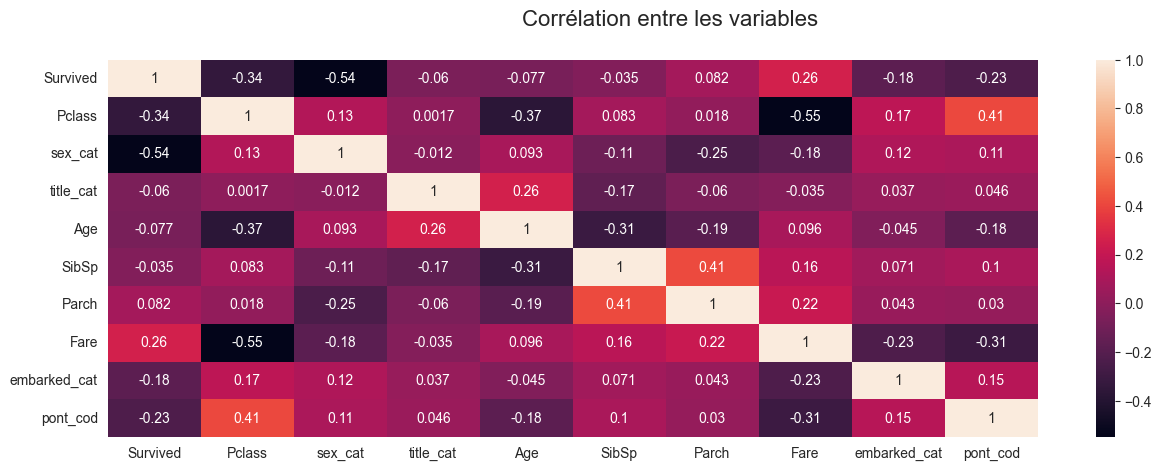

In [119]:
##on utilise data.corr et le heatmap de seborn
corr_df = df.corr()
print("CORR ------------------")
#print(corr_df, "\n")
figure, ax = color_graph_background(1,1)
figure.set_size_inches(15, 5, forward=True)
figure.set_dpi(100)
figure.suptitle("Corrélation entre les variables", fontsize=16)
sns.heatmap(corr_df, annot=True)
plt.show()

## 3.2. Traiter l'âge

In [120]:
df.columns

Index(['Survived', 'Pclass', 'sex_cat', 'Titre', 'title_cat', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked', 'embarked_cat', 'Last_name', 'First_name',
       'deck3', 'pont_cod'],
      dtype='object')

### 3.2.1. AGE > Version manuelle

In [121]:
def calculer_moyenne_on_colums_Save(df_limit, columns_list, columnName_to_cal):
    age_group = df_limit.groupby(by=columns_list)[columnName_to_cal].mean()
    new_col_name = "mean_"+columnName_to_cal
    age_group = age_group.rename(new_col_name)
    # On veut préciser le pont qui a le plus de valeurs
    age_group.sort_values(ascending=False)
    age_group_no_index = age_group.reset_index()
    # essai de traitement manuel

    df_age_manuel = df_limit.copy()
    # on merge les 2
    df_age_manuel = df_age_manuel.merge(age_group_no_index, on=columns_list, how='outer')
    df_age_manuel[new_col_name] = round(df_age_manuel[new_col_name], 0)
    df_age_manuel[columnName_to_cal] = df_age_manuel[columnName_to_cal].fillna(df_age_manuel[new_col_name])
    print(columnName_to_cal+" NA before:",df_limit[columnName_to_cal].isna().sum(),columnName_to_cal+" NA after:", df_age_manuel[columnName_to_cal].isna().sum())
    df_age_manuel = df_age_manuel.drop(new_col_name, axis=1)
    return df_age_manuel


In [122]:
def calculer_moyenne_on_colums(df_limit, columns_list, columnName_to_cal, col_src=None):
    if col_src is None:
        col_src = columnName_to_cal
    age_group = df_limit.groupby(by=columns_list)[col_src].mean()
    new_col_name = "mean_"+columnName_to_cal
    age_group = age_group.rename(new_col_name)
    # On veut préciser le pont qui a le plus de valeurs
    age_group.sort_values(ascending=False)
    age_group_no_index = age_group.reset_index()
    # essai de traitement manuel

    df_age_manuel = df_limit.copy()
    # on merge les 2
    df_age_manuel = df_age_manuel.merge(age_group_no_index, on=columns_list, how='outer')
    df_age_manuel[new_col_name] = round(df_age_manuel[new_col_name], 0)
    df_age_manuel[columnName_to_cal] = df_age_manuel[columnName_to_cal].fillna(df_age_manuel[new_col_name])
    print(columnName_to_cal+" NA before:",df_limit[columnName_to_cal].isna().sum(),columnName_to_cal+" NA after:", df_age_manuel[columnName_to_cal].isna().sum())
    df_age_manuel = df_age_manuel.drop(new_col_name, axis=1)
    return df_age_manuel


In [123]:
age_cols = ['Survived', 'sex_cat', 'Pclass', 'title_cat', 'pont_cod', 'Fare', 'embarked_cat', 'SibSp', 'Parch']
df_age_full = df.copy()
df_age_full["age_manuel"] = df_age_full["Age"]
while (df_age_full['age_manuel'].isna().sum() > 0) & (len(age_cols)>0):
       df_age_full = calculer_moyenne_on_colums(df_age_full,age_cols, 'age_manuel')
       age_cols.pop()

df_age_full

age_manuel NA before: 177 age_manuel NA after: 89
age_manuel NA before: 89 age_manuel NA after: 85
age_manuel NA before: 85 age_manuel NA after: 82
age_manuel NA before: 82 age_manuel NA after: 80
age_manuel NA before: 80 age_manuel NA after: 7
age_manuel NA before: 7 age_manuel NA after: 0


,Survived,Pclass,sex_cat,Titre,title_cat,Age,SibSp,Parch,Fare,Embarked,embarked_cat,Last_name,First_name,deck3,pont_cod,age_manuel
0,0,3,1,Mr,7,22.0,1,0,7.2500,S,2,Braund,Owen Harris,G,6,22.0
1,0,3,1,Mr,7,59.0,0,0,7.2500,S,2,Coxon,Daniel,G,6,59.0
2,0,3,1,Mr,7,22.0,0,0,7.2500,S,2,Perkin,John Henry,G,6,22.0
3,0,3,1,Mr,7,20.5,0,0,7.2500,S,2,Lovell,"John Hall (""Henry"")",G,6,20.5
4,0,3,1,Mr,7,NaN,0,0,7.2500,S,2,Reed,James George,G,6,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,1,1,1,Master,5,4.0,0,2,81.8583,S,2,Dodge,Washington,A,0,4.0
887,1,1,1,Dr,2,50.0,2,0,133.6500,S,2,Frauenthal,Henry William,B,1,50.0
888,1,1,1,Dr,2,32.0,0,0,30.5000,C,0,Stahelin-Maeglin,Max,B,1,32.0
889,1,1,1,Col,1,56.0,0,0,35.5000,C,0,Simonius-Blumer,Oberst Alfons,A,0,56.0


In [124]:
age_cols = ['Survived', 'sex_cat', 'Pclass', 'title_cat', 'pont_cod', 'Fare', 'embarked_cat', 'SibSp', 'Parch']
df_age_full["age_manuel_ctr"] = np.nan
while (df_age_full['age_manuel_ctr'].isna().sum() > 0) & (len(age_cols)>0):
       df_age_full = calculer_moyenne_on_colums(df_age_full,age_cols, 'age_manuel_ctr', 'Age')
       age_cols.pop()

df_age_full

age_manuel_ctr NA before: 891 age_manuel_ctr NA after: 89
age_manuel_ctr NA before: 89 age_manuel_ctr NA after: 85
age_manuel_ctr NA before: 85 age_manuel_ctr NA after: 82
age_manuel_ctr NA before: 82 age_manuel_ctr NA after: 80
age_manuel_ctr NA before: 80 age_manuel_ctr NA after: 7
age_manuel_ctr NA before: 7 age_manuel_ctr NA after: 0


,Survived,Pclass,sex_cat,Titre,title_cat,Age,SibSp,Parch,Fare,Embarked,embarked_cat,Last_name,First_name,deck3,pont_cod,age_manuel,age_manuel_ctr
0,0,3,1,Mr,7,22.0,1,0,7.2500,S,2,Braund,Owen Harris,G,6,22.0,22.0
1,0,3,1,Mr,7,59.0,0,0,7.2500,S,2,Coxon,Daniel,G,6,59.0,31.0
2,0,3,1,Mr,7,22.0,0,0,7.2500,S,2,Perkin,John Henry,G,6,22.0,31.0
3,0,3,1,Mr,7,20.5,0,0,7.2500,S,2,Lovell,"John Hall (""Henry"")",G,6,20.5,31.0
4,0,3,1,Mr,7,NaN,0,0,7.2500,S,2,Reed,James George,G,6,31.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,1,1,1,Master,5,4.0,0,2,81.8583,S,2,Dodge,Washington,A,0,4.0,4.0
887,1,1,1,Dr,2,50.0,2,0,133.6500,S,2,Frauenthal,Henry William,B,1,50.0,50.0
888,1,1,1,Dr,2,32.0,0,0,30.5000,C,0,Stahelin-Maeglin,Max,B,1,32.0,32.0
889,1,1,1,Col,1,56.0,0,0,35.5000,C,0,Simonius-Blumer,Oberst Alfons,A,0,56.0,56.0


### 3.2.1. AGE > Version régression linéaire

<mark>Faire une régression linéaire pour estimer l'âge pour les données manquantes</mark>    
par rapport à la classe, au billet, ....

In [125]:
x_col = ['Survived', 'sex_cat', 'Pclass', 'pont_cod', 'Fare', 'embarked_cat', 'SibSp', 'Parch']
y_col = ["Age"]
all_col= x_col
all_col.extend(y_col)

df_age = df_age_full[all_col]
df_age_x = df_age[df_age["Age"].isna() == False]

df_age_to_predict = df_age[df_age["Age"].isna()]
df_age_to_predict = df_age_to_predict[x_col]

df_age_y = df_age_x[y_col]
df_age_x = df_age_x[x_col]

<AxesSubplot:>

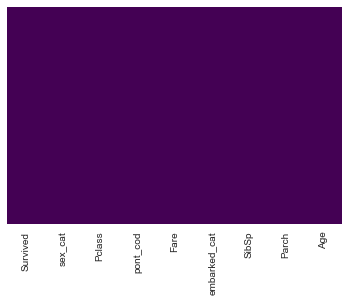

In [126]:
sns.heatmap(df_age_x.isnull(), yticklabels=False,cbar=False,cmap='viridis')

<AxesSubplot:>

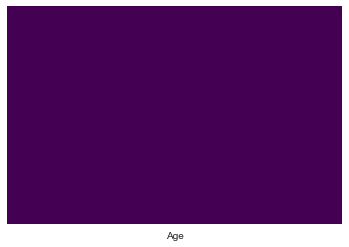

In [127]:
sns.heatmap(df_age_y.isnull(), yticklabels=False,cbar=False,cmap='viridis')

### Estimation de l'âge

In [128]:
age_xtrain, age_xtest, age_ytrain, age_ytest = train_test_split(df_age_x, df_age_y, train_size=0.8)
age_xtrain

,Survived,sex_cat,Pclass,pont_cod,Fare,embarked_cat,SibSp,Parch,Age
242,0,1,3,1,6.4958,2,0,0,34.0
112,0,1,3,6,7.2292,0,1,1,15.0
95,0,1,3,6,7.2250,0,0,0,45.5
444,1,1,1,1,79.2000,0,1,1,60.0
774,0,1,2,5,26.0000,2,1,0,34.0
...,...,...,...,...,...,...,...,...,...
803,0,1,2,6,15.0458,0,0,0,23.0
480,0,0,3,6,7.8958,2,0,0,28.0
551,0,1,1,2,110.8833,0,1,1,49.0
414,1,1,1,4,26.5500,2,0,0,51.0


In [129]:
def draw_regression2(df, col_x, col_y, col_group=None):
    figure, axe = color_graph_background(1,1)

    plt.xlabel(col_x)
    plt.ylabel(col_y)
    # On affiche les données nettoyées
    df.plot.scatter(col_x, col_y, c=col_group, colormap='viridis', ax=axe)

    mini = min(df[col_x])
    maxi = max(df[col_x]) + 1

    X = np.matrix([np.ones(df.shape[0]), df[col_x]]).T
    y = np.matrix(df[col_y]).T
    theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    axe.plot([mini,maxi], [theta.item(0),theta.item(0) + maxi * theta.item(1)], linestyle='--', c='#000000')

    figure.set_size_inches(16, 8, forward=True)
    plt.xticks(rotation=45, ha="right")
    plt.title(col_x + " " + col_y)
    plt.show()

In [130]:
mini = max(df_age_full["Age"])
mini

80.0

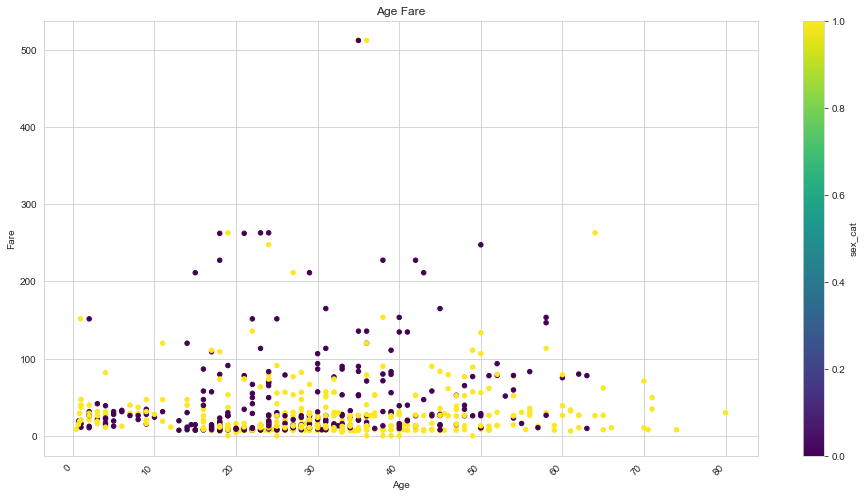

In [131]:
draw_regression2(df_age_full, 'Age', 'Fare', 'sex_cat')

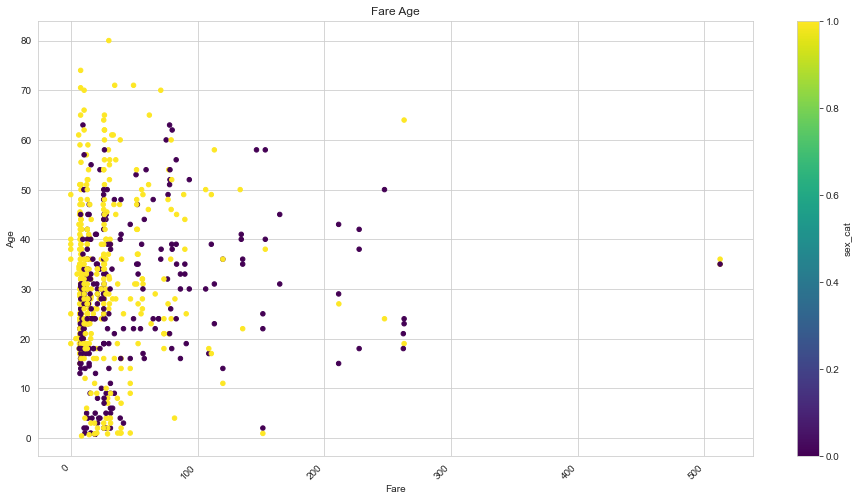

In [132]:
draw_regression2(df_age_full, 'Fare', 'Age', 'sex_cat')

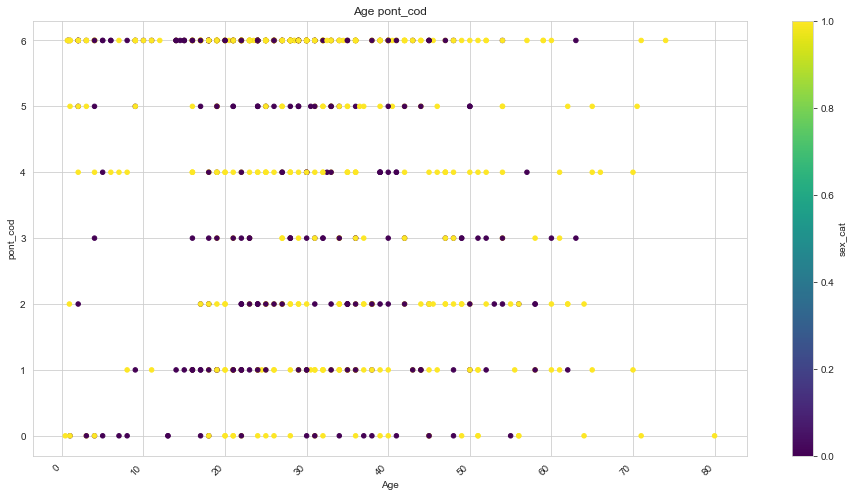

In [133]:
draw_regression2(df_age_full, 'Age', 'pont_cod', 'sex_cat')

In [134]:
df_temp =df_age_x[['Age', 'Fare']]
print(df_temp.shape, df_age_y.shape)


(714, 2) (714, 1)


In [135]:
def draw_regression_3d(df, col_x, col_y, col_hue, col_group=None): 
    fig = plt.figure(figsize=(16, 8)).gca(projection='3d')
    # Pour faciliter la visualisation, on va changer la valeur de l'arrondissement (10)
    tmp_arr = df[col_hue][:]
    if col_group is None:
        fig.scatter(tmp_arr, df[col_x], df[col_y], c=tmp_arr, cmap="viridis")
    else:
        fig.scatter(tmp_arr, df[col_x], df[col_y], c=df[col_group], cmap="viridis")
 
    plt.xlabel(col_hue)
    plt.ylabel(col_x)
    plt.xticks(rotation=45, ha="right")
    plt.title(col_x + " " + col_y)
    plt.show()

C:\Users\User\AppData\Local\Temp/ipykernel_20016/833793316.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  fig = plt.figure(figsize=(16, 8)).gca(projection='3d')


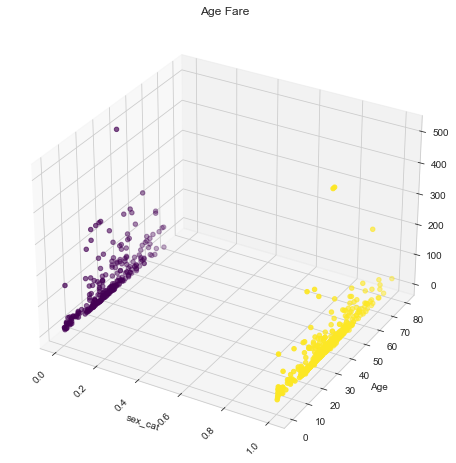

In [136]:
draw_regression_3d(df_age_full, 'Age', "Fare", "sex_cat")

C:\Users\User\AppData\Local\Temp/ipykernel_20016/833793316.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  fig = plt.figure(figsize=(16, 8)).gca(projection='3d')


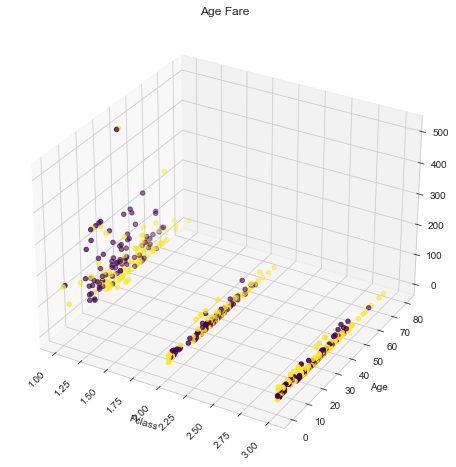

In [137]:
draw_regression_3d(df_age_full,  'Age',"Fare", "Pclass", "sex_cat")

<mark>Faire une régression linéaire pour estimer l'âge pour les données manquantes</mark>    
par rapport à la classe, au billet, ....

Compléter les cabines pour les valeurs manquantes


De nombreuses valeurs manquantes parsèment le jeu de données.
Le nombre sur **Cabin** peut potentiellement facilement s'expliquer assez facilement : cela correspond pour une grande partie à des individus qui n'avaient simplement pas de cabine. En effet seuls les passagers de 1ère classe et certains de 2ème disposaient d'un numéro de cabine pour leur voyage.

Ces cabines étaient répartis entre les ponts A et E pour les 1ère classe, et de D à G pour les autres.
La cabine T est une cabine de classe supérieure située sur le pont A.

Si on observe rapidement la variable Cabin, on peut noter que le première caractère correspond au pont en question. On extrait donc ce dernier et on analyse la répartition des classes au sein des valeurs manquantes sur notre pont.

In [138]:
df_age_full["age_formula"] = df_age_full['Age']

In [139]:
df_age_full.columns

Index(['Survived', 'Pclass', 'sex_cat', 'Titre', 'title_cat', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked', 'embarked_cat', 'Last_name', 'First_name',
       'deck3', 'pont_cod', 'age_manuel', 'age_manuel_ctr', 'age_formula'],
      dtype='object')

In [140]:
mask = df_age_full["age_formula"].notnull()

lr = smf.ols(formula='Age ~ Survived + Pclass + sex_cat + Titre + title_cat + SibSp + Parch + Fare + Embarked + embarked_cat + deck3 + pont_cod',
             data=df_age_full.loc[mask,:]).fit()

df_age_full.loc[~mask, 'age_formula'] = round(lr.predict(df_age_full.loc[~mask,:].drop(columns=['age_formula'])),0)
df_age_full.isnull().sum()

Survived            0
Pclass              0
sex_cat             0
Titre               0
title_cat           0
Age               177
SibSp               0
Parch               0
Fare                0
Embarked            2
embarked_cat        0
Last_name           0
First_name          0
deck3               0
pont_cod            0
age_manuel          0
age_manuel_ctr      0
age_formula         0
dtype: int64

Comparaison des 2 colonnes

In [141]:
df_age_full.columns

Index(['Survived', 'Pclass', 'sex_cat', 'Titre', 'title_cat', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked', 'embarked_cat', 'Last_name', 'First_name',
       'deck3', 'pont_cod', 'age_manuel', 'age_manuel_ctr', 'age_formula'],
      dtype='object')

In [142]:
df_age_temp = df_age_full[['Survived', 'Pclass', 'sex_cat', 'Titre', 'Age', 'Fare', 'Embarked', 
       'deck3', 'age_manuel', 'age_manuel_ctr', 'age_formula']]

In [143]:
df_age_temp[(df_age_temp['age_manuel_ctr'] != df_age_temp['Age']) & (df_age_temp["Age"].notna())]

,Survived,Pclass,sex_cat,Titre,Age,Fare,Embarked,deck3,age_manuel,age_manuel_ctr,age_formula
1,0,3,1,Mr,59.00,7.25,S,G,59.00,31.0,59.00
2,0,3,1,Mr,22.00,7.25,S,G,22.00,31.0,22.00
3,0,3,1,Mr,20.50,7.25,S,G,20.50,31.0,20.50
5,0,3,1,Mr,22.00,7.25,S,G,22.00,31.0,22.00
6,0,3,1,Mr,30.00,7.25,S,G,30.00,31.0,30.00
...,...,...,...,...,...,...,...,...,...,...,...
867,1,2,1,Master,3.00,18.75,S,G,3.00,2.0,3.00
868,1,2,1,Master,0.83,18.75,S,G,0.83,2.0,0.83
871,0,2,0,Miss,24.00,13.00,S,G,24.00,31.0,24.00
872,0,2,0,Miss,38.00,13.00,S,G,38.00,31.0,38.00


In [144]:
df_age_temp["ecart_manuel"] = df_age_temp['Age'] - df_age_temp['age_manuel_ctr']
df_age_temp["ecart_manuel"].value_counts().head(20)

C:\Users\User\AppData\Local\Temp/ipykernel_20016/425357578.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age_temp["ecart_manuel"] = df_age_temp['Age'] - df_age_temp['age_manuel_ctr']


 0.0     388
-1.0      23
 3.0      19
 1.0      19
 2.0      18
-4.0      18
-2.0      16
-8.0      16
-3.0      16
-5.0      14
-6.0      13
-7.0      11
 6.0      11
-10.0      8
 4.0       8
 5.0       7
 0.5       6
 12.0      6
-12.0      5
 13.0      5
Name: ecart_manuel, dtype: int64

Impossible de faire le même contrôle avec la formule

In [145]:
df_age_temp[(df_age_temp['age_formula'] != df_age_temp['Age']) & (df_age_temp["Age"].notna())]

,Survived,Pclass,sex_cat,Titre,Age,Fare,Embarked,deck3,age_manuel,age_manuel_ctr,age_formula,ecart_manuel


In [146]:
df_age_temp[(df_age_temp['age_manuel'] == df_age_temp['age_formula']) & (df_age_temp["Age"].isna())]

,Survived,Pclass,sex_cat,Titre,Age,Fare,Embarked,deck3,age_manuel,age_manuel_ctr,age_formula,ecart_manuel
154,0,3,1,Mr,NaN,16.1000,S,G,27.0,27.0,27.0,NaN
194,0,3,1,Mr,NaN,8.7125,C,A,29.0,29.0,29.0,NaN
312,1,1,0,Mrs,NaN,146.5208,C,B,39.0,39.0,39.0,NaN
382,1,3,1,Mr,NaN,7.7750,S,G,25.0,25.0,25.0,NaN
515,0,3,0,Miss,NaN,7.7500,Q,F,26.0,26.0,26.0,NaN
577,0,1,1,Mr,NaN,27.7208,C,G,40.0,40.0,40.0,NaN
578,0,1,1,Mr,NaN,27.7208,C,G,40.0,40.0,40.0,NaN
628,1,3,0,Mrs,NaN,22.3583,C,F,29.0,29.0,29.0,NaN
877,0,1,1,Dr,NaN,39.6000,C,G,44.0,44.0,44.0,NaN


In [147]:
df_age_temp[(df_age_temp['age_manuel'] != df_age_temp['age_formula']) & (df_age_temp["Age"].isna())]

,Survived,Pclass,sex_cat,Titre,Age,Fare,Embarked,deck3,age_manuel,age_manuel_ctr,age_formula,ecart_manuel
4,0,3,1,Mr,NaN,7.2500,S,G,31.0,31.0,29.0,NaN
7,0,3,1,Mr,NaN,7.2500,S,G,31.0,31.0,29.0,NaN
8,0,3,1,Mr,NaN,7.2500,S,G,31.0,31.0,29.0,NaN
16,0,3,1,Mr,NaN,7.3125,S,G,28.0,28.0,29.0,NaN
31,0,3,1,Mr,NaN,7.8958,S,G,27.0,27.0,29.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
815,0,2,1,Mr,NaN,0.0000,S,G,32.0,32.0,36.0,NaN
816,0,2,1,Mr,NaN,0.0000,S,G,32.0,32.0,36.0,NaN
817,0,2,1,Mr,NaN,0.0000,S,G,32.0,32.0,36.0,NaN
818,0,2,1,Mr,NaN,0.0000,S,G,32.0,32.0,36.0,NaN


* 9 âges identiques avec les deux formules
* 168 différences de calcul d'age avec les deux formules

In [148]:
df_age_temp["diff_formula_manuel"] = df_age_temp['age_formula'] - df_age_temp['age_manuel']
df_age_temp["diff_formula_manuel"].value_counts()

C:\Users\User\AppData\Local\Temp/ipykernel_20016/727164344.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age_temp["diff_formula_manuel"] = df_age_temp['age_formula'] - df_age_temp['age_manuel']


 0.0     723
 2.0      27
-2.0      18
 3.0      14
 4.0      13
 1.0      11
-1.0       9
-12.0      9
-5.0       8
 6.0       7
-7.0       6
 5.0       6
-4.0       5
-13.0      4
-8.0       4
-6.0       4
-17.0      4
-14.0      3
 10.0      3
 13.0      2
-15.0      1
-21.0      1
 8.0       1
-18.0      1
-11.0      1
 7.0       1
 11.0      1
 21.0      1
 12.0      1
 9.0       1
 16.0      1
Name: diff_formula_manuel, dtype: int64

## 3.3. Suppression des colonnes inutiles

In [149]:
df_age_full.head()

,Survived,Pclass,sex_cat,Titre,title_cat,Age,SibSp,Parch,Fare,Embarked,embarked_cat,Last_name,First_name,deck3,pont_cod,age_manuel,age_manuel_ctr,age_formula
0,0,3,1,Mr,7,22.0,1,0,7.25,S,2,Braund,Owen Harris,G,6,22.0,22.0,22.0
1,0,3,1,Mr,7,59.0,0,0,7.25,S,2,Coxon,Daniel,G,6,59.0,31.0,59.0
2,0,3,1,Mr,7,22.0,0,0,7.25,S,2,Perkin,John Henry,G,6,22.0,31.0,22.0
3,0,3,1,Mr,7,20.5,0,0,7.25,S,2,Lovell,"John Hall (""Henry"")",G,6,20.5,31.0,20.5
4,0,3,1,Mr,7,NaN,0,0,7.25,S,2,Reed,James George,G,6,31.0,31.0,29.0


In [150]:
df_age_full.columns

Index(['Survived', 'Pclass', 'sex_cat', 'Titre', 'title_cat', 'Age', 'SibSp',
       'Parch', 'Fare', 'Embarked', 'embarked_cat', 'Last_name', 'First_name',
       'deck3', 'pont_cod', 'age_manuel', 'age_manuel_ctr', 'age_formula'],
      dtype='object')

In [151]:
df_age_full['family_on_board'] = df_age_full['SibSp'] + df_age_full['Parch']

In [152]:
df_clean = df_age_full[['Survived', 'Pclass', 'sex_cat', 'Titre', 'title_cat', 'age_formula', 'family_on_board',
                        'Fare', 'embarked_cat', 'deck3', 'pont_cod', 'Last_name', 'First_name']]

In [153]:
df_clean = df_clean.rename(columns={'deck3':'Deck', 'age_formula':"Age", 'sex_cat':'sex_cod', 'title_cat':'title_cod', 'embarked_cat':'embarked_cod', 'pont_cod':'deck_cod'})
df_clean.head()

,Survived,Pclass,sex_cod,Titre,title_cod,Age,family_on_board,Fare,embarked_cod,Deck,deck_cod,Last_name,First_name
0,0,3,1,Mr,7,22.0,1,7.25,2,G,6,Braund,Owen Harris
1,0,3,1,Mr,7,59.0,0,7.25,2,G,6,Coxon,Daniel
2,0,3,1,Mr,7,22.0,0,7.25,2,G,6,Perkin,John Henry
3,0,3,1,Mr,7,20.5,0,7.25,2,G,6,Lovell,"John Hall (""Henry"")"
4,0,3,1,Mr,7,29.0,0,7.25,2,G,6,Reed,James George


Vérifiez la taille de votre data, supprimer les valeurs manquantes

In [154]:
df_clean.isna().sum()

Survived           0
Pclass             0
sex_cod            0
Titre              0
title_cod          0
Age                0
family_on_board    0
Fare               0
embarked_cod       0
Deck               0
deck_cod           0
Last_name          0
First_name         0
dtype: int64

# Analyse des données

## 4.1. Corrélation

CORR ------------------


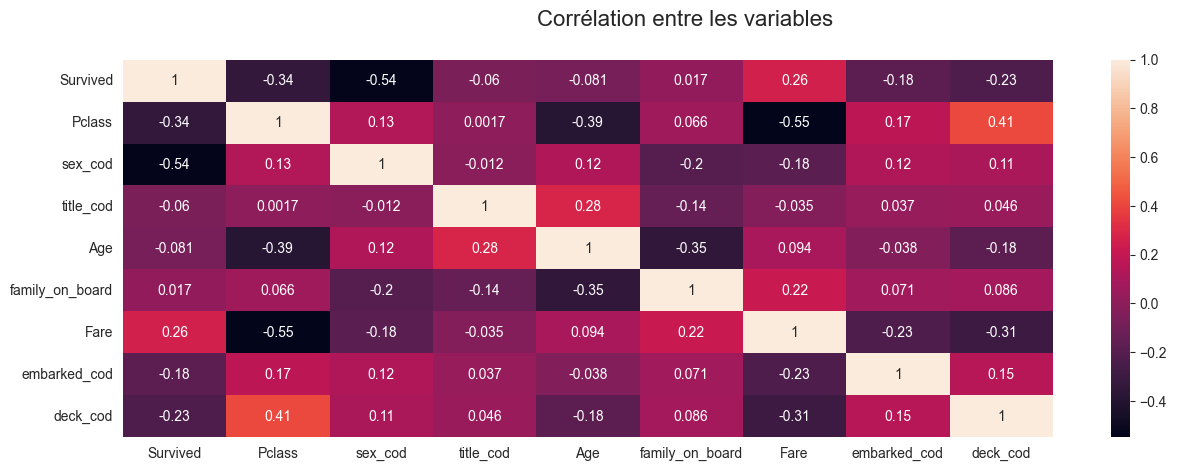

In [155]:
##on utilise data.corr et le heatmap de seborn
corr_df = df_clean.corr()
print("CORR ------------------")
#print(corr_df, "\n")
figure, ax = color_graph_background(1,1)
figure.set_size_inches(15, 5, forward=True)
figure.set_dpi(100)
figure.suptitle("Corrélation entre les variables", fontsize=16)
sns.heatmap(corr_df, annot=True)
plt.show()

In [156]:
df_clean.columns

Index(['Survived', 'Pclass', 'sex_cod', 'Titre', 'title_cod', 'Age',
       'family_on_board', 'Fare', 'embarked_cod', 'Deck', 'deck_cod',
       'Last_name', 'First_name'],
      dtype='object')

<AxesSubplot:xlabel='Survived', ylabel='Age'>

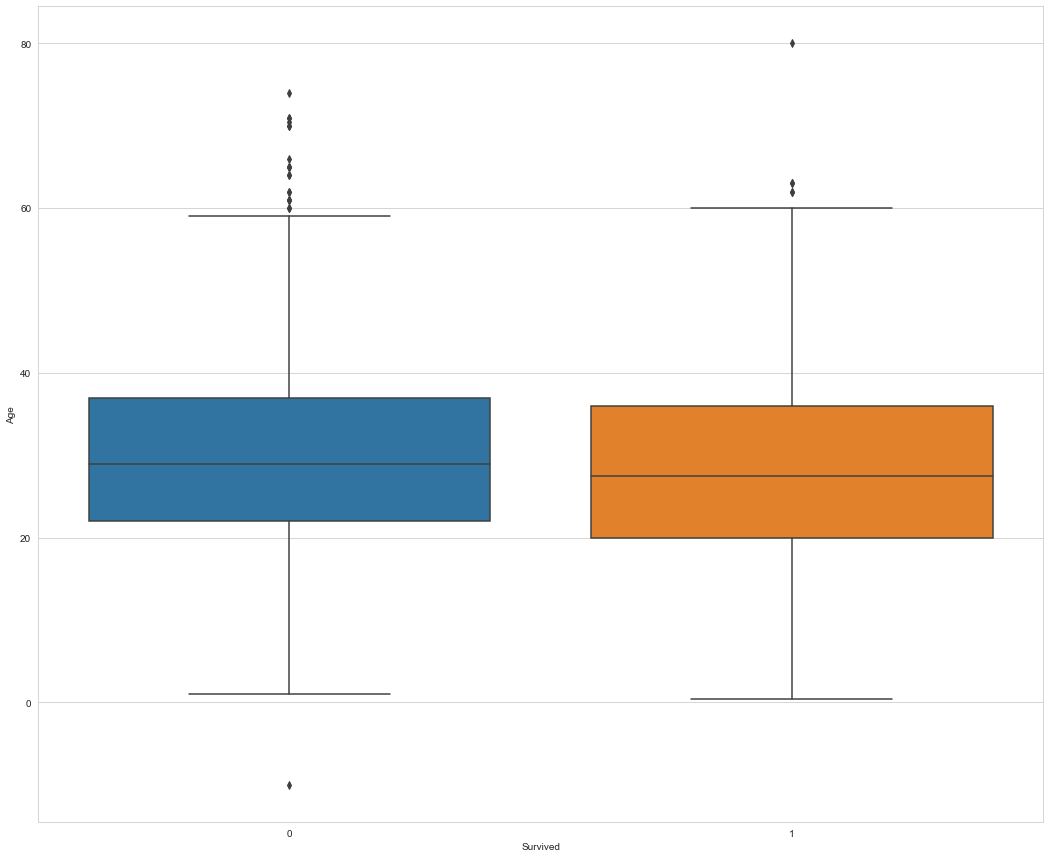

In [157]:
plt.figure(figsize=(18,15))
sns.boxplot(data=df_clean[['Age','Survived']],x='Survived',y='Age')

<AxesSubplot:xlabel='Titre', ylabel='Age'>

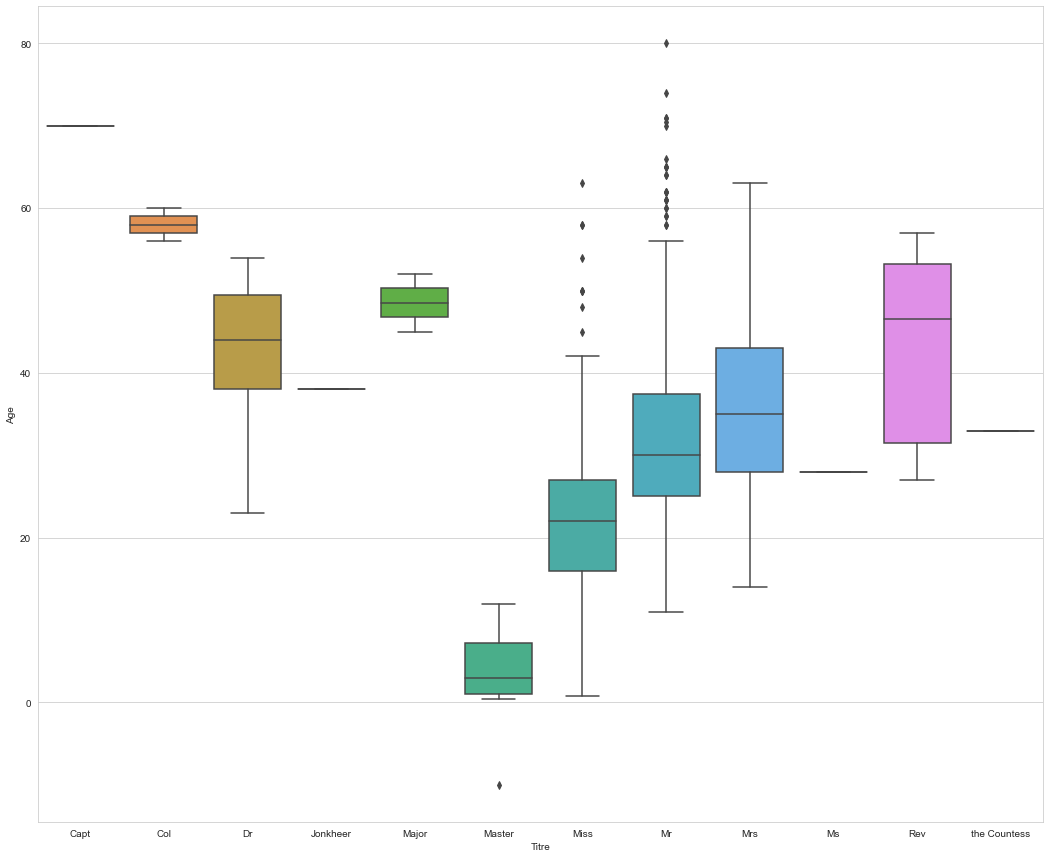

In [158]:
plt.figure(figsize=(18,15))
sns.boxplot(data=df_clean[['Age','Titre']],x='Titre',y='Age')

<AxesSubplot:xlabel='Deck', ylabel='Age'>

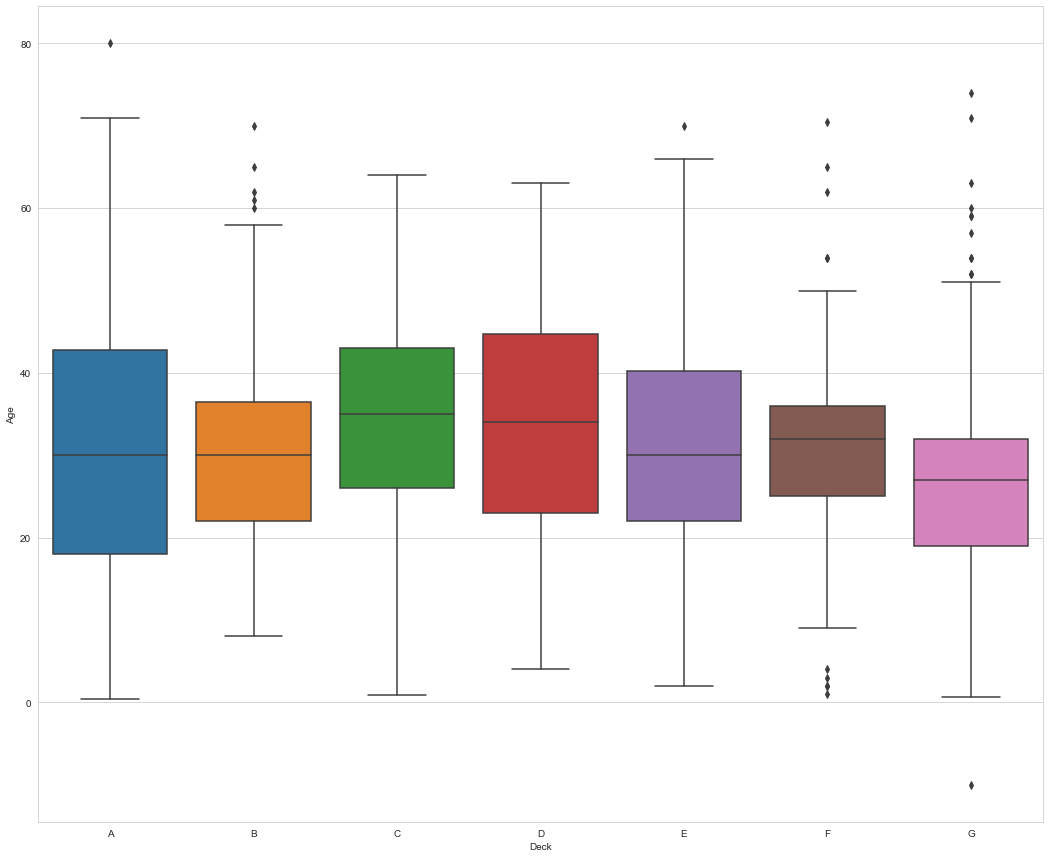

In [159]:
plt.figure(figsize=(18,15))
sns.boxplot(data=df_clean[['Age','Deck']],x='Deck',y='Age')

# Machine Learning

La compétition a été l’occasion de revenir sur ce jeu de données très célèbre, et plusieurs tâches étaient attendues, :
- identifier les facteurs favorisants la survie d'un passager par rapport à un autre, en dressant une typologie des survivants
- créer un algorithme qui pourrait prédire la survie d'un individu à partir de ces caractéristiques.

Vous avez été ajouté à une équipe et le travail et lancé depuis quelques semaines : à cette étape,  la mission est en réalité finie (c.f. le présent notebook). Vos co-équipiers ont travaillé dur : il faut dans un premier temps vous approprier leur travail.

In [160]:
df_clean.columns

Index(['Survived', 'Pclass', 'sex_cod', 'Titre', 'title_cod', 'Age',
       'family_on_board', 'Fare', 'embarked_cod', 'Deck', 'deck_cod',
       'Last_name', 'First_name'],
      dtype='object')

In [161]:
to_predict_columns = 'Survived'
columns = ['Survived', 'Pclass', 'sex_cod', 'title_cod', 'Age',
              'family_on_board', 'Fare', 'embarked_cod', 'deck_cod'] 

# Il faut faire le split avant pour avoir toujours la même répartition pour comparer les différents résultats
X_train, X_test, y_train, y_test = train_test_split(df_clean.drop(columns=[to_predict_columns]), df_clean[to_predict_columns], train_size=0.8)

In [201]:
model_knn_save_path = "Titanic_model_KNN_score_0.9_2022-01-12.joblib"

model_knn_save_exist = False
try:
    with open(file_path+ model_knn_save_path): model_knn_save_exist=True
except IOError:
    pass

In [202]:
model_knn_save_exist

True

## 5.1. KNeighborsClassifier

### 5.1.1 KNN

In [162]:
def knn_found_better_neigbors(x, y, x_test, y_test, knn_min=1, knn_max=10, plot=False):
    res = {}
    better_score = 0
    better_n=0
    for i in range (knn_min, knn_max):
        model = KNeighborsClassifier(n_neighbors=i) 
        model.fit(x, y)
        score_test = model.score(x_test,y_test)
        score_train = model.score(x,y)
        res[i] = (model, score_test, score_train)
        if score_test > better_score:
            better_score = score_test
            better_n = i
    # print(f"{round(better_score,2)} de test <=> {round(better_score_train,2)} de train, KNN {better_n}, columns:{x.columns}")
    model, score_test, score_train = res[better_n]
    return model, score_test, score_train, better_n, res

In [163]:
def knn_found_better_config(X_train, X_test, y_train, y_test, knn_min=1, knn_max=10, plot=False):

    # on prend un maximum de colonne pour commencer
    to_predict_columns = 'Survived'
    
    columns_started = ['Pclass', 'sex_cod', 'title_cod', 'Age', 'family_on_board', 'Fare', 'embarked_cod', 'deck_cod']
    ever_test = []
    better_score = 0
    better_score_train = 0
    better_n_global=0
    better_model = None
    better_columns = None
    better_key = None
    test_res = {}
    # train_res = {}
    # Modifier l'ordre des colonnes pour trouver encore d'autres configurations pertinentes
    # Positionnement de 6 suite aux tests lancés et des premiers résultats
    for subset in itertools.permutations(columns_started, 6):
        columns = list(subset)
                
        # a chaque tour, on regardera le meilleur score
        while len(columns)>0:
            str_col = str(sorted(columns))
            if str_col not in ever_test:
                model, score_test, score_train, better_n, _ = knn_found_better_neigbors(X_train[columns], y_train, X_test[columns], y_test, knn_min, knn_max, plot)
                
                # on stocke le résultat pour plus tard
                list_temp = test_res.get(score_test, {})
                list_temp[str_col] = (model, score_test, score_train, better_n)
                test_res[score_test] = list_temp

                # list_temp = train_res.get(score_train, {})
                # list_temp[str_col] = (model, score_test, score_train, better_n)
                # train_res[score_test] = list_temp

                ever_test.append(str_col)
                if score_test > better_score:
                    better_score = score_test
                    better_columns = columns
                    better_key = str(columns)
                    better_model = model
                    better_n_global = better_n
                    better_score_train = score_train
                    print(f"--------------------------------------------------------------------------------------------------------")
                    print(f"New Best :{round(better_score,2)} de test <=> {round(better_score_train,2)} de train, KNN = {better_n_global} :{better_key}")
                    print(f"--------------------------------------------------------------------------------------------------------")
                else:
                    print(f"{round(score_test,2)} de test <=> {round(score_train,2)} de train, KNN = {better_n} :{columns}")
            # On supprime une colonne
            columns.pop()
        #print(f"{round(better_score,2)} de test <=> {round(better_score_train,2)} de train, KNN = {better_n_global} colonnes : {better_key} (started with:{save_init_col})")
    print(f"--------------------------------------------------------------------------------------------------------")
    print(f"Score {round(better_score,2)} de test <=> {round(better_score_train,2)} de train, KNN= {better_n_global} avec les colonnes : {better_key}")
    return better_model, better_columns, test_res, better_score


In [164]:
# Mise en commentaire pour ne traiter que lorsque le meilleur modèle n'a pas été sauvegardé.
# better_model, better_columns, test_res = knn_found_better_config(X_train, X_test, y_train, y_test, knn_min=1, knn_max=10, plot=False)

--------------------------------------------------------------------------------------------------------
New Best :0.75 de test <=> 0.83 de train, KNN = 3 :['Pclass', 'sex_cod', 'title_cod', 'Age', 'family_on_board', 'Fare']
--------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------
New Best :0.83 de test <=> 0.86 de train, KNN = 3 :['Pclass', 'sex_cod', 'title_cod', 'Age', 'family_on_board']
--------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------
New Best :0.84 de test <=> 0.81 de train, KNN = 7 :['Pclass', 'sex_cod', 'title_cod', 'Age']
--------------------------------------------------------------------------------------------------------
---------------------------------------------

La meilleure configuration sur la base du score de test est (exécution = nouveau train et nouveau test) :
* Exécution 1: 0.89 de test <=> 0.85 de train, KNN = 4 :['Pclass', 'sex_cod', 'title_cod', 'family_on_board', 'embarked_cod', 'deck_cod']
* Exécution 2: 0.87 de test <=> 0.82 de train, KNN= 5 avec les colonnes : ['Pclass', 'sex_cod', 'title_cod', 'embarked_cod']
* Exécution 3: 
   * 0.82 de test <=> 0.86 de train, KNN = 2 :['Pclass', 'sex_cod', 'family_on_board', 'embarked_cod', 'deck_cod']
   * 0.82 de test <=> 0.85 de train, KNN = 4 :['Pclass', 'sex_cod', 'title_cod', 'embarked_cod', 'deck_cod']
   * 0.82 de test <=> 0.82 de train, KNN = 3 :['Pclass', 'sex_cod', 'family_on_board', 'embarked_cod']
   * 0.82 de test <=> 0.86 de train, KNN = 4 :['Pclass', 'title_cod', 'embarked_cod', 'deck_cod']
* Exécution 4:
   * 0.9 de test <=> 0.83 de train, KNN= 7 avec les colonnes : ['Pclass', 'sex_cod', 'title_cod', 'embarked_cod', 'deck_cod']


In [211]:
better_model = None
if model_knn_save_exist:
    better_model = load(file_path+ model_knn_save_path)
    score_test = better_model.score(X_test[['Pclass', 'sex_cod', 'title_cod', 'embarked_cod', 'deck_cod']],y_test)
    print(better_model, round(score_test, 2))
else:
    better_model, better_columns, test_res, better_score = knn_found_better_config(X_train, X_test, y_train, y_test, knn_min=1, knn_max=10, plot=False)
    # Sauvegarde du meilleur modele
    now = datetime.now() # current date and time
    date_time = now.strftime("%Y-%m-%d-%H_%M_%S")
    # Attention, il faudra mettre à jour les colonnes correspondantes dans le premier if en cas de modification du model
    dump(better_model, file_path+'Titanic_model_saved_score_'+str(round(better_score,2))+'_' + date_time + '.joblib')

KNeighborsClassifier(n_neighbors=7) 0.9


In [212]:
def knn_predire_survie(model, pclass=3, sex=1, age=40, title=6, deck = randint(0, 6), embarked_cod = randint(-1, 2)):
    deck = randint(0, 6)
    embarked_cod = randint(-1, 2)
    # ['Pclass', 'sex_cod', 'title_cod', 'embarked_cod', 'deck_cod']
    params = [pclass, sex, title, embarked_cod, deck]
    x = np.array(params).reshape(1, len(params))
    print(params, "=", model.predict(x), model.predict_proba(x))
    return model.predict(x), model.predict_proba(x)

In [213]:
titres_dic = {"Mr" : 7, "Miss" : 6, "Mrs" : 8, "Master" : 5, "Dr" : 2, "Rev" : 6}


In [215]:
col = ['Pclass', 'sex_cod', 'title_cod', 'embarked_cod', 'deck_cod']
print("Miss")
print(f"{col}, [proba]")
knn_predire_survie(better_model, pclass=3, sex=1, age=40, title=titres_dic["Miss"])
knn_predire_survie(better_model, pclass=2, sex=1, age=40, title=titres_dic["Miss"])
knn_predire_survie(better_model, pclass=1, sex=1, age=40, title=titres_dic["Miss"])
print("Mrs")
print(f"{col}, [proba]")
knn_predire_survie(better_model, pclass=3, sex=1, age=40, title=titres_dic["Mrs"])
knn_predire_survie(better_model, pclass=2, sex=1, age=40, title=titres_dic["Mrs"])
knn_predire_survie(better_model, pclass=1, sex=1, age=40, title=titres_dic["Mrs"])
print("Mr")
print(f"{col}, [proba]")
knn_predire_survie(better_model, pclass=3, sex=0, age=40, title=titres_dic["Mr"])
knn_predire_survie(better_model, pclass=2, sex=0, age=40, title=titres_dic["Mr"])
knn_predire_survie(better_model, pclass=1, sex=0, age=40, title=titres_dic["Mr"])
print("Master")
print(f"{col}, [proba]")
knn_predire_survie(better_model, pclass=3, sex=0, age=40, title=titres_dic["Master"])
knn_predire_survie(better_model, pclass=2, sex=0, age=40, title=titres_dic["Master"])
knn_predire_survie(better_model, pclass=1, sex=0, age=40, title=titres_dic["Master"])

Miss
['Pclass', 'sex_cod', 'title_cod', 'embarked_cod', 'deck_cod'], [proba]
[3, 1, 6, 2, 4] = [1] [[0.28571429 0.71428571]]
[2, 1, 6, -1, 0] = [1] [[0.14285714 0.85714286]]
[1, 1, 6, 2, 1] = [1] [[0. 1.]]
Mrs
['Pclass', 'sex_cod', 'title_cod', 'embarked_cod', 'deck_cod'], [proba]
[3, 1, 8, 2, 2] = [0] [[1. 0.]]
[2, 1, 8, 2, 2] = [0] [[0.85714286 0.14285714]]
[1, 1, 8, 1, 1] = [1] [[0.28571429 0.71428571]]
Mr
['Pclass', 'sex_cod', 'title_cod', 'embarked_cod', 'deck_cod'], [proba]
[3, 0, 7, 1, 6] = [1] [[0.42857143 0.57142857]]
[2, 0, 7, -1, 1] = [1] [[0. 1.]]
[1, 0, 7, 2, 2] = [0] [[0.71428571 0.28571429]]
Master
['Pclass', 'sex_cod', 'title_cod', 'embarked_cod', 'deck_cod'], [proba]
[3, 0, 5, 1, 3] = [0] [[0.71428571 0.28571429]]
[2, 0, 5, 2, 4] = [1] [[0. 1.]]
[1, 0, 5, -1, 6] = [1] [[0.28571429 0.71428571]]


C:\Program Files\Python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Program Files\Python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Program Files\Python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Program Files\Python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Program Files\Python39\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Program Files\Python39\lib\site-packages\sklearn\base.py:445: 

(array([1], dtype=int64), array([[0.28571429, 0.71428571]]))

Sauvegarde du model car j'aurai du mal à avoir un meilleur score que 0.9

## 5.2. LogisticRegression

## 5.3. RandomForestClassifier

* LogisticRegression
* RandomForestClassifier
j'ai essayé le random forest sur ton fichier, j'ai eu un score de 0,85  et en ajoutant une colonne titre comme 'Countess,Major ...' j'arrive à avoir un score de 0,86
oui, avec les variables catégorielles comme le deck par exemple tu peux utiliser le from sklearn.preprocessing import OrdinalEncoder pour qu'elle soit exploitable par l'algorithme de machine learning
* KNeighborsClassifier

In [ ]:
data_ia['Sex'] = data_ia['Sex'].astype('category').cat.codes
data_ia['Deck'] = data_ia['Deck'].astype('category').cat.codes
data_ia['Embarked'] = data_ia['Embarked'].astype('category').cat.codes

In [ ]:
test['Sex'] = test['Sex'].map( {'female': 1, 'male': 0} ).astype(int) 

une question à réfléchir pourquoi OrdinalEncoder()
 pas LabelEncoder()